<a href="https://colab.research.google.com/github/naimurborno/Microcontroller-detection/blob/testing/Microcontroller_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"naimurborno","key":"23e5db83d73f578cfeb8e9b31f47105c"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!pip install kaggle

In [5]:
!kaggle datasets download -d tannergi/microcontroller-detection

 96% 8.00M/8.34M [00:00<00:00, 83.5MB/s]
100% 8.34M/8.34M [00:00<00:00, 86.0MB/s]


In [6]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub
import cv2

In [7]:
import zipfile
with zipfile.ZipFile("/content/microcontroller-detection.zip") as z:
  z.extractall()


In [8]:
dataset_path="/content/Microcontroller Detection"

In [9]:
train_dataset=os.path.join(dataset_path,"train")
test_dataset=os.path.join(dataset_path,"test")
train_labels=os.path.join(dataset_path,"train_labels.csv")
test_labels=os.path.join(dataset_path,"test_labels.csv")

In [10]:
train_labels_dataset=pd.read_csv(train_labels)

In [11]:
import tensorflow
from tensorflow import keras

In [12]:
model=tensorflow_hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2",input_shape=(128,128,3))

In [14]:
input=tf.keras.layers.Input(shape=(128,128,3))
x=model(input)
x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(100,activation='relu')(x)
x=tf.keras.layers.Dense(128,activation='relu')(x)
cls=tf.keras.layers.Dense(4,activation='softmax',name="classification")(x)
x=tf.keras.layers.Dense(100,activation='relu')(x)
cor=tf.keras.layers.Dense(4,name='Regression')(x)
model1=tf.keras.Model(inputs=input,outputs=[cls,cor])

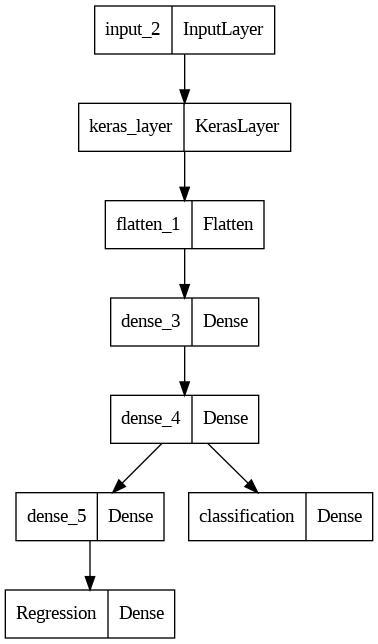

In [15]:
tf.keras.utils.plot_model(model1)

In [16]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 keras_layer (KerasLayer)    (None, 1001)                 1692489   ['input_2[0][0]']             
                                                                                                  
 flatten_1 (Flatten)         (None, 1001)                 0         ['keras_layer[1][0]']         
                                                                                                  
 dense_3 (Dense)             (None, 100)                  100200    ['flatten_1[0][0]']           
                                                                                            

In [17]:
train_labels_dataset['class'].unique()

array(['Arduino_Nano', 'Heltec_ESP32_Lora', 'ESP8266', 'Raspberry_Pi_3'],
      dtype=object)

In [18]:
class_dict={'Arduino_Nano':0, 'Heltec_ESP32_Lora':1, 'ESP8266':2, 'Raspberry_Pi_3':3}
reverse_class_dict={value:key for key,value in class_dict.items()}

In [19]:
reverse_class_dict

{0: 'Arduino_Nano', 1: 'Heltec_ESP32_Lora', 2: 'ESP8266', 3: 'Raspberry_Pi_3'}

In [20]:
class_dict["Arduino_Nano"]

0

In [21]:
train_labels_dataset.loc[train_labels_dataset['class']=="Arduino_Nano",'class']=0

In [22]:
train_labels_dataset.loc[train_labels_dataset['class']=='Heltec_ESP32_Lora','class']=1

In [23]:
train_labels_dataset.loc[train_labels_dataset['class']=='ESP8266','class']=2

In [24]:
train_labels_dataset.loc[train_labels_dataset['class']=='Raspberry_Pi_3','class']=3

In [ ]:
128/600

0.21333333333333335

In [25]:
train_labels_dataset['xmin']=train_labels_dataset['xmin']*.16

In [26]:
train_labels_dataset['ymin']=train_labels_dataset['ymin']*.21
train_labels_dataset['xmax']=train_labels_dataset['xmax']*.16
train_labels_dataset['ymax']=train_labels_dataset['ymax']*.21

In [27]:
train_labels_dataset['xmin']=train_labels_dataset['xmin'].astype(np.int64)
train_labels_dataset['ymin']=train_labels_dataset['ymin'].astype(np.int64)
train_labels_dataset['xmax']=train_labels_dataset['xmax'].astype(np.int64)
train_labels_dataset['ymax']=train_labels_dataset['ymax'].astype(np.int64)

In [28]:
train_labels_dataset.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,IMG_20181228_101826.jpg,800,600,0,50,55,88,71
1,IMG_20181228_101855.jpg,800,600,1,63,51,94,80
2,IMG_20181228_101903.jpg,800,600,2,46,50,82,81
3,IMG_20181228_101915.jpg,800,600,3,31,42,107,111
4,IMG_20181228_102013.jpg,800,600,0,61,70,94,93


In [29]:
from sklearn.preprocessing import LabelEncoder

In [30]:
encoder=LabelEncoder()

In [31]:
train_labels_dataset['class']=train_labels_dataset['class'].astype(np.int64)

In [32]:
train_labels_dataset.dtypes

filename    object
width        int64
height       int64
class        int64
xmin         int64
ymin         int64
xmax         int64
ymax         int64
dtype: object

In [33]:
train_labels_dataset.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,IMG_20181228_101826.jpg,800,600,0,50,55,88,71
1,IMG_20181228_101855.jpg,800,600,1,63,51,94,80
2,IMG_20181228_101903.jpg,800,600,2,46,50,82,81
3,IMG_20181228_101915.jpg,800,600,3,31,42,107,111
4,IMG_20181228_102013.jpg,800,600,0,61,70,94,93


In [34]:
X=[]
y1=[]
y2=[]
for row,labels in enumerate(train_labels_dataset['filename']):
  path=os.path.join(train_dataset,labels)
  image=cv2.imread(path)
  image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  image=cv2.resize(image,(128,128))
  X.append(image)

  #y.append(train_labels_dataset[3:8])
  y1.append(train_labels_dataset.loc[row,['class']])
  y2.append(train_labels_dataset.loc[row,['xmin','ymin','xmax','ymax']])


In [35]:
y1=pd.DataFrame(y1)
y2=pd.DataFrame(y2)

In [36]:
from sklearn.preprocessing import OneHotEncoder

In [37]:
encoder=OneHotEncoder(sparse=False)

In [38]:
y1=encoder.fit_transform(y1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [39]:
y1

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],


In [47]:
np.argmax(y1[0])

0

In [48]:
def print_image_with_box(index):
  image=X[index]
  cls=np.argmax(y1[index])
  xmin=y2['xmin'][index]
  ymin=y2['ymin'][index]
  xmax=y2['xmax'][index]
  ymax=y2['ymax'][index]
  image=cv2.rectangle(image,(xmin,ymin),(xmax,ymax),(100,0,0),1)
  image = cv2.putText(image, reverse_class_dict[cls], (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1, cv2.LINE_AA)
  return image,cls

Arduino_Nano


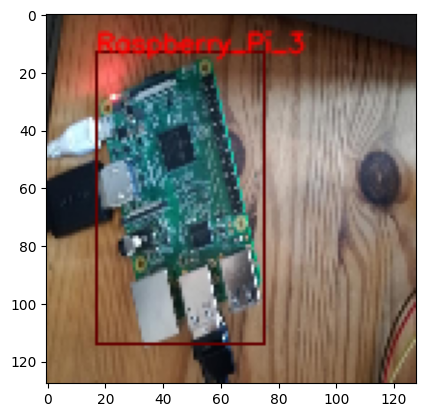

In [53]:
image,name=print_image_with_box(50)
print(reverse_class_dict[np.argmax(name)])
plt.imshow(image)

In [54]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 keras_layer (KerasLayer)    (None, 1001)                 1692489   ['input_2[0][0]']             
                                                                                                  
 flatten_1 (Flatten)         (None, 1001)                 0         ['keras_layer[1][0]']         
                                                                                                  
 dense_3 (Dense)             (None, 100)                  100200    ['flatten_1[0][0]']           
                                                                                            

In [55]:
X=np.array(X)
y1=np.array(y1)
y2=np.array(y2)

In [56]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 keras_layer (KerasLayer)    (None, 1001)                 1692489   ['input_2[0][0]']             
                                                                                                  
 flatten_1 (Flatten)         (None, 1001)                 0         ['keras_layer[1][0]']         
                                                                                                  
 dense_3 (Dense)             (None, 100)                  100200    ['flatten_1[0][0]']           
                                                                                            

In [57]:
X=X/255

In [ ]:
X

In [ ]:
y1

In [60]:
!pip install mlflow --quiet
get_ipython().system_raw("mlflow ui --port 5000 &")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 5.9 MB/s eta 0:00:00


In [ ]:
!pip install pyngrok --quiet

from pyngrok import ngrok
from getpass import getpass

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = getpass('Enter the ngrok authtoken: ')
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

Enter the ngrok authtoken: ··········
MLflow Tracking UI: https://19c7-34-143-197-37.ngrok-free.app


In [73]:
!pip install mlflow --quiet

import mlflow
import os
from getpass import getpass

In [ ]:
# MLFLOW_TRACKING_URI=https://dagshub.com/naimurborno/Microcontroller-detection.mlflow \
# MLFLOW_TRACKING_USERNAME=naimurborno \
# MLFLOW_TRACKING_PASSWORD=your_token

In [80]:
os.environ['MLFLOW_TRACKING_USERNAME'] ='naimurborno'
os.environ['MLFLOW_TRACKING_PASSWORD'] ='94ebc629914b4f17304744d67eec0b421a8f74d1'
os.environ['MLFLOW_TRACKING_PROJECTNAME'] ='Microcontroller-detection'

In [ ]:
import mlflow

In [93]:
mlflow.set_tracking_uri('https://dagshub.com/naimurborno/Microcontroller-detection.mlflow')
with mlflow.start_run():
  mlflow.tensorflow.autolog()
  model1.compile(
      optimizer='adam',
      loss={"classification":'categorical_crossentropy','Regression':'mean_squared_error'},
      metrics={'classification':'accuracy','Regression':'mae'}
  )
  history=model1.fit(X,
                    {'classification':y1,'Regression':y2},
                    epochs=300)



2024/03/09 05:28:04 INFO mlflow.types.utils: MLflow 2.9.0 introduces model signature with new data types for lists and dictionaries. For input such as Dict[str, Union[scalars, List, Dict]], we infer dictionary values types as `List -> Array` and `Dict -> Object`. 


Epoch 1/300
4/6 [===================>..........] - ETA: 0s - loss: 182.3571 - classification_loss: 0.4102 - Regression_loss: 181.9469 - classification_accuracy: 0.8047 - Regression_mae: 8.3533 

2024/03/09 05:28:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 3s 21ms/step - loss: 191.4491 - classification_loss: 0.3993 - Regression_loss: 191.0497 - classification_accuracy: 0.8118 - Regression_mae: 8.5214
Epoch 2/300
5/6 [========================>.....] - ETA: 0s - loss: 164.9474 - classification_loss: 0.3692 - Regression_loss: 164.5782 - classification_accuracy: 0.8500 - Regression_mae: 7.6789

2024/03/09 05:28:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 17ms/step - loss: 158.2582 - classification_loss: 0.3668 - Regression_loss: 157.8914 - classification_accuracy: 0.8529 - Regression_mae: 7.4804
Epoch 3/300
5/6 [========================>.....] - ETA: 0s - loss: 150.1063 - classification_loss: 0.4086 - Regression_loss: 149.6977 - classification_accuracy: 0.8500 - Regression_mae: 6.5593

2024/03/09 05:28:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 155.1163 - classification_loss: 0.4151 - Regression_loss: 154.7012 - classification_accuracy: 0.8471 - Regression_mae: 6.7717
Epoch 4/300
4/6 [===================>..........] - ETA: 0s - loss: 153.1431 - classification_loss: 0.4192 - Regression_loss: 152.7239 - classification_accuracy: 0.8359 - Regression_mae: 7.0625

2024/03/09 05:28:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 158.2197 - classification_loss: 0.4031 - Regression_loss: 157.8166 - classification_accuracy: 0.8412 - Regression_mae: 6.8032
Epoch 5/300
5/6 [========================>.....] - ETA: 0s - loss: 149.5910 - classification_loss: 0.3273 - Regression_loss: 149.2637 - classification_accuracy: 0.8500 - Regression_mae: 7.1593

2024/03/09 05:28:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 17ms/step - loss: 161.8407 - classification_loss: 0.3351 - Regression_loss: 161.5056 - classification_accuracy: 0.8471 - Regression_mae: 7.3320
Epoch 6/300
4/6 [===================>..........] - ETA: 0s - loss: 159.5617 - classification_loss: 0.3509 - Regression_loss: 159.2107 - classification_accuracy: 0.8438 - Regression_mae: 7.1251

2024/03/09 05:28:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 156.6602 - classification_loss: 0.3553 - Regression_loss: 156.3049 - classification_accuracy: 0.8412 - Regression_mae: 6.9818
Epoch 7/300
5/6 [========================>.....] - ETA: 0s - loss: 156.6937 - classification_loss: 0.3497 - Regression_loss: 156.3440 - classification_accuracy: 0.8562 - Regression_mae: 6.8895

2024/03/09 05:28:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 157.1207 - classification_loss: 0.3650 - Regression_loss: 156.7557 - classification_accuracy: 0.8529 - Regression_mae: 6.8928
Epoch 8/300
5/6 [========================>.....] - ETA: 0s - loss: 160.0039 - classification_loss: 0.3735 - Regression_loss: 159.6304 - classification_accuracy: 0.8438 - Regression_mae: 7.2896

2024/03/09 05:28:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 157.5475 - classification_loss: 0.3790 - Regression_loss: 157.1685 - classification_accuracy: 0.8412 - Regression_mae: 7.2634
Epoch 9/300
5/6 [========================>.....] - ETA: 0s - loss: 159.5458 - classification_loss: 0.3704 - Regression_loss: 159.1754 - classification_accuracy: 0.8313 - Regression_mae: 7.2699

2024/03/09 05:28:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 160.5658 - classification_loss: 0.3786 - Regression_loss: 160.1872 - classification_accuracy: 0.8235 - Regression_mae: 7.2878
Epoch 10/300
5/6 [========================>.....] - ETA: 0s - loss: 150.0512 - classification_loss: 0.3448 - Regression_loss: 149.7065 - classification_accuracy: 0.8500 - Regression_mae: 6.8730

2024/03/09 05:28:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 17ms/step - loss: 160.8610 - classification_loss: 0.3543 - Regression_loss: 160.5067 - classification_accuracy: 0.8412 - Regression_mae: 7.1378
Epoch 11/300
5/6 [========================>.....] - ETA: 0s - loss: 154.5776 - classification_loss: 0.3237 - Regression_loss: 154.2539 - classification_accuracy: 0.8562 - Regression_mae: 6.4999

2024/03/09 05:28:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 17ms/step - loss: 152.6728 - classification_loss: 0.3266 - Regression_loss: 152.3461 - classification_accuracy: 0.8529 - Regression_mae: 6.4796
Epoch 12/300
5/6 [========================>.....] - ETA: 0s - loss: 156.9993 - classification_loss: 0.3571 - Regression_loss: 156.6422 - classification_accuracy: 0.8313 - Regression_mae: 6.7469

2024/03/09 05:28:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 20ms/step - loss: 153.6220 - classification_loss: 0.3445 - Regression_loss: 153.2775 - classification_accuracy: 0.8412 - Regression_mae: 6.5744
Epoch 13/300
4/6 [===================>..........] - ETA: 0s - loss: 159.4808 - classification_loss: 0.3204 - Regression_loss: 159.1603 - classification_accuracy: 0.8594 - Regression_mae: 6.5862

2024/03/09 05:28:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 150.8922 - classification_loss: 0.3564 - Regression_loss: 150.5358 - classification_accuracy: 0.8412 - Regression_mae: 6.4306
Epoch 14/300
5/6 [========================>.....] - ETA: 0s - loss: 152.1783 - classification_loss: 0.3339 - Regression_loss: 151.8444 - classification_accuracy: 0.8375 - Regression_mae: 6.5234

2024/03/09 05:28:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 17ms/step - loss: 153.0085 - classification_loss: 0.3345 - Regression_loss: 152.6740 - classification_accuracy: 0.8412 - Regression_mae: 6.4791
Epoch 15/300
5/6 [========================>.....] - ETA: 0s - loss: 151.2274 - classification_loss: 0.3482 - Regression_loss: 150.8791 - classification_accuracy: 0.8125 - Regression_mae: 6.0852

2024/03/09 05:28:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 150.4016 - classification_loss: 0.3718 - Regression_loss: 150.0298 - classification_accuracy: 0.8000 - Regression_mae: 6.1349
Epoch 16/300
5/6 [========================>.....] - ETA: 0s - loss: 150.0236 - classification_loss: 0.3187 - Regression_loss: 149.7048 - classification_accuracy: 0.8500 - Regression_mae: 6.6566

2024/03/09 05:28:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 17ms/step - loss: 155.9704 - classification_loss: 0.3417 - Regression_loss: 155.6287 - classification_accuracy: 0.8353 - Regression_mae: 6.8133
Epoch 17/300
5/6 [========================>.....] - ETA: 0s - loss: 167.7817 - classification_loss: 0.3723 - Regression_loss: 167.4094 - classification_accuracy: 0.8125 - Regression_mae: 7.3719

2024/03/09 05:28:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 17ms/step - loss: 158.2544 - classification_loss: 0.3573 - Regression_loss: 157.8971 - classification_accuracy: 0.8235 - Regression_mae: 7.0579
Epoch 18/300
5/6 [========================>.....] - ETA: 0s - loss: 163.0203 - classification_loss: 0.3459 - Regression_loss: 162.6744 - classification_accuracy: 0.8375 - Regression_mae: 6.8948

2024/03/09 05:28:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 17ms/step - loss: 155.0894 - classification_loss: 0.3425 - Regression_loss: 154.7469 - classification_accuracy: 0.8412 - Regression_mae: 6.6932
Epoch 19/300
5/6 [========================>.....] - ETA: 0s - loss: 148.4137 - classification_loss: 0.3200 - Regression_loss: 148.0937 - classification_accuracy: 0.8250 - Regression_mae: 6.1330

2024/03/09 05:28:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 150.0712 - classification_loss: 0.3248 - Regression_loss: 149.7464 - classification_accuracy: 0.8235 - Regression_mae: 6.2159
Epoch 20/300
5/6 [========================>.....] - ETA: 0s - loss: 161.5296 - classification_loss: 0.3496 - Regression_loss: 161.1800 - classification_accuracy: 0.8313 - Regression_mae: 7.1596

2024/03/09 05:28:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 17ms/step - loss: 158.0739 - classification_loss: 0.3421 - Regression_loss: 157.7319 - classification_accuracy: 0.8412 - Regression_mae: 6.9749
Epoch 21/300
4/6 [===================>..........] - ETA: 0s - loss: 133.4779 - classification_loss: 0.2912 - Regression_loss: 133.1866 - classification_accuracy: 0.8516 - Regression_mae: 6.1383

2024/03/09 05:28:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 20ms/step - loss: 152.4472 - classification_loss: 0.3247 - Regression_loss: 152.1225 - classification_accuracy: 0.8294 - Regression_mae: 6.6800
Epoch 22/300
4/6 [===================>..........] - ETA: 0s - loss: 138.6170 - classification_loss: 0.2696 - Regression_loss: 138.3474 - classification_accuracy: 0.8750 - Regression_mae: 6.4461

2024/03/09 05:28:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 157.5813 - classification_loss: 0.3280 - Regression_loss: 157.2532 - classification_accuracy: 0.8294 - Regression_mae: 6.9634
Epoch 23/300
5/6 [========================>.....] - ETA: 0s - loss: 153.3999 - classification_loss: 0.3190 - Regression_loss: 153.0809 - classification_accuracy: 0.8562 - Regression_mae: 7.6443

2024/03/09 05:28:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 17ms/step - loss: 158.8021 - classification_loss: 0.3319 - Regression_loss: 158.4702 - classification_accuracy: 0.8529 - Regression_mae: 7.7897
Epoch 24/300
5/6 [========================>.....] - ETA: 0s - loss: 156.6412 - classification_loss: 0.3650 - Regression_loss: 156.2763 - classification_accuracy: 0.8188 - Regression_mae: 7.2227

2024/03/09 05:28:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 156.0210 - classification_loss: 0.3662 - Regression_loss: 155.6548 - classification_accuracy: 0.8235 - Regression_mae: 7.3292
Epoch 25/300
5/6 [========================>.....] - ETA: 0s - loss: 146.2591 - classification_loss: 0.3179 - Regression_loss: 145.9411 - classification_accuracy: 0.8562 - Regression_mae: 6.7331

2024/03/09 05:28:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 17ms/step - loss: 156.3065 - classification_loss: 0.3426 - Regression_loss: 155.9639 - classification_accuracy: 0.8471 - Regression_mae: 6.9968
Epoch 26/300
4/6 [===================>..........] - ETA: 0s - loss: 173.7350 - classification_loss: 0.3954 - Regression_loss: 173.3396 - classification_accuracy: 0.8047 - Regression_mae: 7.8616

2024/03/09 05:28:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 160.8966 - classification_loss: 0.3650 - Regression_loss: 160.5316 - classification_accuracy: 0.8235 - Regression_mae: 7.5842
Epoch 27/300
4/6 [===================>..........] - ETA: 0s - loss: 168.8587 - classification_loss: 0.3919 - Regression_loss: 168.4668 - classification_accuracy: 0.8203 - Regression_mae: 7.4970

2024/03/09 05:28:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 156.4566 - classification_loss: 0.3502 - Regression_loss: 156.1064 - classification_accuracy: 0.8471 - Regression_mae: 7.2798
Epoch 28/300
5/6 [========================>.....] - ETA: 0s - loss: 155.6043 - classification_loss: 0.3213 - Regression_loss: 155.2831 - classification_accuracy: 0.8438 - Regression_mae: 6.9218

2024/03/09 05:28:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 161.5606 - classification_loss: 0.3248 - Regression_loss: 161.2358 - classification_accuracy: 0.8471 - Regression_mae: 7.1167
Epoch 29/300
5/6 [========================>.....] - ETA: 0s - loss: 163.6826 - classification_loss: 0.3434 - Regression_loss: 163.3393 - classification_accuracy: 0.8125 - Regression_mae: 6.9761

2024/03/09 05:28:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 156.4058 - classification_loss: 0.3291 - Regression_loss: 156.0767 - classification_accuracy: 0.8235 - Regression_mae: 6.8069
Epoch 30/300
4/6 [===================>..........] - ETA: 0s - loss: 132.1499 - classification_loss: 0.3150 - Regression_loss: 131.8349 - classification_accuracy: 0.8359 - Regression_mae: 6.4609

2024/03/09 05:28:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 153.4590 - classification_loss: 0.3208 - Regression_loss: 153.1381 - classification_accuracy: 0.8412 - Regression_mae: 6.7778
Epoch 31/300
5/6 [========================>.....] - ETA: 0s - loss: 163.0804 - classification_loss: 0.3407 - Regression_loss: 162.7397 - classification_accuracy: 0.8375 - Regression_mae: 7.4239

2024/03/09 05:28:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 17ms/step - loss: 159.6128 - classification_loss: 0.3369 - Regression_loss: 159.2760 - classification_accuracy: 0.8353 - Regression_mae: 7.3307
Epoch 32/300
5/6 [========================>.....] - ETA: 0s - loss: 163.3349 - classification_loss: 0.3409 - Regression_loss: 162.9940 - classification_accuracy: 0.8250 - Regression_mae: 7.2376

2024/03/09 05:28:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 17ms/step - loss: 158.9759 - classification_loss: 0.3326 - Regression_loss: 158.6433 - classification_accuracy: 0.8353 - Regression_mae: 7.1745
Epoch 33/300
5/6 [========================>.....] - ETA: 0s - loss: 153.3338 - classification_loss: 0.3359 - Regression_loss: 152.9979 - classification_accuracy: 0.8188 - Regression_mae: 6.7520

2024/03/09 05:28:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 150.4598 - classification_loss: 0.3287 - Regression_loss: 150.1311 - classification_accuracy: 0.8235 - Regression_mae: 6.6731
Epoch 34/300
5/6 [========================>.....] - ETA: 0s - loss: 163.9767 - classification_loss: 0.3489 - Regression_loss: 163.6277 - classification_accuracy: 0.8438 - Regression_mae: 7.2397

2024/03/09 05:28:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 17ms/step - loss: 159.5745 - classification_loss: 0.3419 - Regression_loss: 159.2325 - classification_accuracy: 0.8471 - Regression_mae: 7.0990
Epoch 35/300
5/6 [========================>.....] - ETA: 0s - loss: 160.3984 - classification_loss: 0.3423 - Regression_loss: 160.0561 - classification_accuracy: 0.8313 - Regression_mae: 7.2767

2024/03/09 05:28:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 155.8300 - classification_loss: 0.3359 - Regression_loss: 155.4941 - classification_accuracy: 0.8353 - Regression_mae: 7.1259
Epoch 36/300
5/6 [========================>.....] - ETA: 0s - loss: 147.0763 - classification_loss: 0.3192 - Regression_loss: 146.7571 - classification_accuracy: 0.8375 - Regression_mae: 6.3564

2024/03/09 05:28:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 153.1773 - classification_loss: 0.3269 - Regression_loss: 152.8504 - classification_accuracy: 0.8353 - Regression_mae: 6.5936
Epoch 37/300
5/6 [========================>.....] - ETA: 0s - loss: 150.0423 - classification_loss: 0.3101 - Regression_loss: 149.7322 - classification_accuracy: 0.8500 - Regression_mae: 6.3621

2024/03/09 05:28:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 154.0766 - classification_loss: 0.3210 - Regression_loss: 153.7556 - classification_accuracy: 0.8471 - Regression_mae: 6.5086
Epoch 38/300
5/6 [========================>.....] - ETA: 0s - loss: 156.0967 - classification_loss: 0.3395 - Regression_loss: 155.7572 - classification_accuracy: 0.8438 - Regression_mae: 6.7171

2024/03/09 05:28:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 153.0659 - classification_loss: 0.3266 - Regression_loss: 152.7394 - classification_accuracy: 0.8529 - Regression_mae: 6.5129
Epoch 39/300
4/6 [===================>..........] - ETA: 0s - loss: 161.8858 - classification_loss: 0.3425 - Regression_loss: 161.5432 - classification_accuracy: 0.8281 - Regression_mae: 7.2027

2024/03/09 05:28:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 26ms/step - loss: 151.6798 - classification_loss: 0.3377 - Regression_loss: 151.3421 - classification_accuracy: 0.8353 - Regression_mae: 6.6750
Epoch 40/300
4/6 [===================>..........] - ETA: 0s - loss: 138.8136 - classification_loss: 0.2964 - Regression_loss: 138.5172 - classification_accuracy: 0.8594 - Regression_mae: 6.1563

2024/03/09 05:28:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 24ms/step - loss: 150.1463 - classification_loss: 0.3248 - Regression_loss: 149.8215 - classification_accuracy: 0.8471 - Regression_mae: 6.3968
Epoch 41/300
4/6 [===================>..........] - ETA: 0s - loss: 133.7389 - classification_loss: 0.2756 - Regression_loss: 133.4633 - classification_accuracy: 0.8672 - Regression_mae: 5.8772

2024/03/09 05:28:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 25ms/step - loss: 154.0599 - classification_loss: 0.3147 - Regression_loss: 153.7452 - classification_accuracy: 0.8412 - Regression_mae: 6.5909
Epoch 42/300
4/6 [===================>..........] - ETA: 0s - loss: 170.0508 - classification_loss: 0.3309 - Regression_loss: 169.7200 - classification_accuracy: 0.8125 - Regression_mae: 7.0011

2024/03/09 05:28:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 22ms/step - loss: 154.8154 - classification_loss: 0.3239 - Regression_loss: 154.4916 - classification_accuracy: 0.8118 - Regression_mae: 6.5853
Epoch 43/300
4/6 [===================>..........] - ETA: 0s - loss: 136.2739 - classification_loss: 0.2859 - Regression_loss: 135.9880 - classification_accuracy: 0.8594 - Regression_mae: 5.7570

2024/03/09 05:28:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 23ms/step - loss: 150.5689 - classification_loss: 0.3097 - Regression_loss: 150.2592 - classification_accuracy: 0.8412 - Regression_mae: 6.3030
Epoch 44/300
4/6 [===================>..........] - ETA: 0s - loss: 152.6385 - classification_loss: 0.3133 - Regression_loss: 152.3252 - classification_accuracy: 0.8594 - Regression_mae: 6.3368

2024/03/09 05:28:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 20ms/step - loss: 151.7489 - classification_loss: 0.3482 - Regression_loss: 151.4007 - classification_accuracy: 0.8412 - Regression_mae: 6.2648
Epoch 45/300
4/6 [===================>..........] - ETA: 0s - loss: 163.2141 - classification_loss: 0.3655 - Regression_loss: 162.8486 - classification_accuracy: 0.8359 - Regression_mae: 6.8496

2024/03/09 05:28:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 23ms/step - loss: 151.9807 - classification_loss: 0.3352 - Regression_loss: 151.6455 - classification_accuracy: 0.8529 - Regression_mae: 6.3286
Epoch 46/300
6/6 [==============================] - ETA: 0s - loss: 149.6306 - classification_loss: 0.3397 - Regression_loss: 149.2910 - classification_accuracy: 0.8412 - Regression_mae: 6.1443

2024/03/09 05:28:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 24ms/step - loss: 149.6306 - classification_loss: 0.3397 - Regression_loss: 149.2910 - classification_accuracy: 0.8412 - Regression_mae: 6.1443
Epoch 47/300
4/6 [===================>..........] - ETA: 0s - loss: 145.7191 - classification_loss: 0.3462 - Regression_loss: 145.3728 - classification_accuracy: 0.8438 - Regression_mae: 6.3930

2024/03/09 05:28:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 21ms/step - loss: 154.6474 - classification_loss: 0.3603 - Regression_loss: 154.2871 - classification_accuracy: 0.8294 - Regression_mae: 6.5974
Epoch 48/300
4/6 [===================>..........] - ETA: 0s - loss: 146.5698 - classification_loss: 0.3001 - Regression_loss: 146.2698 - classification_accuracy: 0.8594 - Regression_mae: 6.0275

2024/03/09 05:28:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 21ms/step - loss: 150.6987 - classification_loss: 0.3250 - Regression_loss: 150.3736 - classification_accuracy: 0.8353 - Regression_mae: 6.2375
Epoch 49/300
4/6 [===================>..........] - ETA: 0s - loss: 163.4433 - classification_loss: 0.3205 - Regression_loss: 163.1228 - classification_accuracy: 0.8516 - Regression_mae: 6.6031

2024/03/09 05:28:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 21ms/step - loss: 154.4720 - classification_loss: 0.3192 - Regression_loss: 154.1528 - classification_accuracy: 0.8471 - Regression_mae: 6.4466
Epoch 50/300
4/6 [===================>..........] - ETA: 0s - loss: 152.9094 - classification_loss: 0.3148 - Regression_loss: 152.5946 - classification_accuracy: 0.8281 - Regression_mae: 7.0644

2024/03/09 05:28:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 23ms/step - loss: 157.3373 - classification_loss: 0.3219 - Regression_loss: 157.0155 - classification_accuracy: 0.8294 - Regression_mae: 7.1333
Epoch 51/300
4/6 [===================>..........] - ETA: 0s - loss: 142.4598 - classification_loss: 0.3137 - Regression_loss: 142.1461 - classification_accuracy: 0.8281 - Regression_mae: 6.2417

2024/03/09 05:28:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 23ms/step - loss: 154.2238 - classification_loss: 0.3234 - Regression_loss: 153.9004 - classification_accuracy: 0.8294 - Regression_mae: 6.4809
Epoch 52/300
4/6 [===================>..........] - ETA: 0s - loss: 157.3307 - classification_loss: 0.3057 - Regression_loss: 157.0250 - classification_accuracy: 0.8516 - Regression_mae: 6.8656

2024/03/09 05:28:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 26ms/step - loss: 154.0744 - classification_loss: 0.3051 - Regression_loss: 153.7693 - classification_accuracy: 0.8471 - Regression_mae: 6.7682
Epoch 53/300
4/6 [===================>..........] - ETA: 0s - loss: 158.2997 - classification_loss: 0.3157 - Regression_loss: 157.9841 - classification_accuracy: 0.8516 - Regression_mae: 6.8717

2024/03/09 05:28:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 26ms/step - loss: 152.7630 - classification_loss: 0.3204 - Regression_loss: 152.4426 - classification_accuracy: 0.8471 - Regression_mae: 6.6930
Epoch 54/300
4/6 [===================>..........] - ETA: 0s - loss: 166.5695 - classification_loss: 0.3144 - Regression_loss: 166.2551 - classification_accuracy: 0.8516 - Regression_mae: 7.2542

2024/03/09 05:28:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 23ms/step - loss: 156.6025 - classification_loss: 0.3104 - Regression_loss: 156.2921 - classification_accuracy: 0.8471 - Regression_mae: 6.9656
Epoch 55/300
4/6 [===================>..........] - ETA: 0s - loss: 139.3380 - classification_loss: 0.2955 - Regression_loss: 139.0426 - classification_accuracy: 0.8516 - Regression_mae: 6.2060

2024/03/09 05:28:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 26ms/step - loss: 151.9130 - classification_loss: 0.3131 - Regression_loss: 151.5999 - classification_accuracy: 0.8353 - Regression_mae: 6.5169
Epoch 56/300
4/6 [===================>..........] - ETA: 0s - loss: 136.1370 - classification_loss: 0.2682 - Regression_loss: 135.8688 - classification_accuracy: 0.8672 - Regression_mae: 5.9846

2024/03/09 05:28:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 25ms/step - loss: 152.1631 - classification_loss: 0.3097 - Regression_loss: 151.8534 - classification_accuracy: 0.8353 - Regression_mae: 6.5769
Epoch 57/300
4/6 [===================>..........] - ETA: 0s - loss: 175.2949 - classification_loss: 0.3615 - Regression_loss: 174.9334 - classification_accuracy: 0.8125 - Regression_mae: 7.6085

2024/03/09 05:28:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 20ms/step - loss: 154.9792 - classification_loss: 0.3242 - Regression_loss: 154.6550 - classification_accuracy: 0.8353 - Regression_mae: 6.7964
Epoch 58/300
4/6 [===================>..........] - ETA: 0s - loss: 162.6570 - classification_loss: 0.3413 - Regression_loss: 162.3157 - classification_accuracy: 0.8281 - Regression_mae: 7.4282

2024/03/09 05:28:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 23ms/step - loss: 158.5534 - classification_loss: 0.3410 - Regression_loss: 158.2124 - classification_accuracy: 0.8294 - Regression_mae: 7.2617
Epoch 59/300
4/6 [===================>..........] - ETA: 0s - loss: 150.1224 - classification_loss: 0.2964 - Regression_loss: 149.8260 - classification_accuracy: 0.8594 - Regression_mae: 8.1820

2024/03/09 05:28:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 23ms/step - loss: 171.8823 - classification_loss: 0.3363 - Regression_loss: 171.5460 - classification_accuracy: 0.8294 - Regression_mae: 8.4195
Epoch 60/300
4/6 [===================>..........] - ETA: 0s - loss: 163.8847 - classification_loss: 0.3192 - Regression_loss: 163.5655 - classification_accuracy: 0.8438 - Regression_mae: 8.3245

2024/03/09 05:28:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 24ms/step - loss: 173.8215 - classification_loss: 0.3172 - Regression_loss: 173.5042 - classification_accuracy: 0.8412 - Regression_mae: 8.3996
Epoch 61/300
4/6 [===================>..........] - ETA: 0s - loss: 173.7520 - classification_loss: 0.3297 - Regression_loss: 173.4223 - classification_accuracy: 0.8125 - Regression_mae: 7.4775

2024/03/09 05:28:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 23ms/step - loss: 168.7298 - classification_loss: 0.3313 - Regression_loss: 168.3985 - classification_accuracy: 0.8176 - Regression_mae: 7.5297
Epoch 62/300
4/6 [===================>..........] - ETA: 0s - loss: 169.0239 - classification_loss: 0.3674 - Regression_loss: 168.6565 - classification_accuracy: 0.8203 - Regression_mae: 7.5042

2024/03/09 05:28:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 20ms/step - loss: 160.6931 - classification_loss: 0.3489 - Regression_loss: 160.3443 - classification_accuracy: 0.8294 - Regression_mae: 7.2076
Epoch 63/300
4/6 [===================>..........] - ETA: 0s - loss: 134.7429 - classification_loss: 0.3040 - Regression_loss: 134.4389 - classification_accuracy: 0.8594 - Regression_mae: 6.6212

2024/03/09 05:28:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 155.8424 - classification_loss: 0.3152 - Regression_loss: 155.5272 - classification_accuracy: 0.8353 - Regression_mae: 6.7493
Epoch 64/300
4/6 [===================>..........] - ETA: 0s - loss: 168.0648 - classification_loss: 0.3928 - Regression_loss: 167.6720 - classification_accuracy: 0.8125 - Regression_mae: 7.2516

2024/03/09 05:28:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 153.4953 - classification_loss: 0.3438 - Regression_loss: 153.1515 - classification_accuracy: 0.8353 - Regression_mae: 6.5720
Epoch 65/300
5/6 [========================>.....] - ETA: 0s - loss: 158.4531 - classification_loss: 0.3255 - Regression_loss: 158.1276 - classification_accuracy: 0.8438 - Regression_mae: 6.4042

2024/03/09 05:28:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 20ms/step - loss: 151.4632 - classification_loss: 0.3225 - Regression_loss: 151.1407 - classification_accuracy: 0.8471 - Regression_mae: 6.2427
Epoch 66/300
5/6 [========================>.....] - ETA: 0s - loss: 148.3649 - classification_loss: 0.3198 - Regression_loss: 148.0451 - classification_accuracy: 0.8562 - Regression_mae: 6.1280

2024/03/09 05:28:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 150.1384 - classification_loss: 0.3279 - Regression_loss: 149.8105 - classification_accuracy: 0.8412 - Regression_mae: 6.1933
Epoch 67/300
5/6 [========================>.....] - ETA: 0s - loss: 153.3149 - classification_loss: 0.3229 - Regression_loss: 152.9920 - classification_accuracy: 0.8313 - Regression_mae: 6.2138

2024/03/09 05:28:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 20ms/step - loss: 150.5106 - classification_loss: 0.3128 - Regression_loss: 150.1978 - classification_accuracy: 0.8412 - Regression_mae: 6.1823
Epoch 68/300
5/6 [========================>.....] - ETA: 0s - loss: 158.3512 - classification_loss: 0.3232 - Regression_loss: 158.0280 - classification_accuracy: 0.8375 - Regression_mae: 6.4997

2024/03/09 05:28:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 20ms/step - loss: 150.4094 - classification_loss: 0.3103 - Regression_loss: 150.0992 - classification_accuracy: 0.8471 - Regression_mae: 6.2472
Epoch 69/300
5/6 [========================>.....] - ETA: 0s - loss: 147.9012 - classification_loss: 0.2989 - Regression_loss: 147.6022 - classification_accuracy: 0.8438 - Regression_mae: 5.9794

2024/03/09 05:28:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 150.0385 - classification_loss: 0.3090 - Regression_loss: 149.7294 - classification_accuracy: 0.8412 - Regression_mae: 6.1049
Epoch 70/300
4/6 [===================>..........] - ETA: 0s - loss: 131.7982 - classification_loss: 0.2815 - Regression_loss: 131.5168 - classification_accuracy: 0.8359 - Regression_mae: 5.6587

2024/03/09 05:28:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 151.2783 - classification_loss: 0.3165 - Regression_loss: 150.9618 - classification_accuracy: 0.8176 - Regression_mae: 6.1585
Epoch 71/300
4/6 [===================>..........] - ETA: 0s - loss: 150.6722 - classification_loss: 0.2968 - Regression_loss: 150.3754 - classification_accuracy: 0.8359 - Regression_mae: 5.9328

2024/03/09 05:28:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 150.9253 - classification_loss: 0.3096 - Regression_loss: 150.6158 - classification_accuracy: 0.8176 - Regression_mae: 6.1591
Epoch 72/300
5/6 [========================>.....] - ETA: 0s - loss: 141.3945 - classification_loss: 0.3006 - Regression_loss: 141.0939 - classification_accuracy: 0.8438 - Regression_mae: 5.9936

2024/03/09 05:28:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 149.1401 - classification_loss: 0.3071 - Regression_loss: 148.8330 - classification_accuracy: 0.8353 - Regression_mae: 6.1336
Epoch 73/300
5/6 [========================>.....] - ETA: 0s - loss: 146.7988 - classification_loss: 0.2847 - Regression_loss: 146.5141 - classification_accuracy: 0.8500 - Regression_mae: 5.9993

2024/03/09 05:28:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 149.9230 - classification_loss: 0.3108 - Regression_loss: 149.6122 - classification_accuracy: 0.8294 - Regression_mae: 6.1547
Epoch 74/300
4/6 [===================>..........] - ETA: 0s - loss: 130.0203 - classification_loss: 0.3060 - Regression_loss: 129.7143 - classification_accuracy: 0.8438 - Regression_mae: 5.9766

2024/03/09 05:28:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 22ms/step - loss: 153.2868 - classification_loss: 0.3297 - Regression_loss: 152.9570 - classification_accuracy: 0.8412 - Regression_mae: 6.4877
Epoch 75/300
4/6 [===================>..........] - ETA: 0s - loss: 146.8823 - classification_loss: 0.3113 - Regression_loss: 146.5710 - classification_accuracy: 0.8438 - Regression_mae: 6.8572

2024/03/09 05:28:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 25ms/step - loss: 158.3848 - classification_loss: 0.3306 - Regression_loss: 158.0542 - classification_accuracy: 0.8294 - Regression_mae: 7.2174
Epoch 76/300
4/6 [===================>..........] - ETA: 0s - loss: 157.4657 - classification_loss: 0.3085 - Regression_loss: 157.1572 - classification_accuracy: 0.8203 - Regression_mae: 7.4975

2024/03/09 05:28:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 26ms/step - loss: 163.9994 - classification_loss: 0.3179 - Regression_loss: 163.6815 - classification_accuracy: 0.8176 - Regression_mae: 7.7009
Epoch 77/300
4/6 [===================>..........] - ETA: 0s - loss: 155.3380 - classification_loss: 0.3192 - Regression_loss: 155.0188 - classification_accuracy: 0.8359 - Regression_mae: 7.2029

2024/03/09 05:28:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 22ms/step - loss: 153.7343 - classification_loss: 0.3409 - Regression_loss: 153.3934 - classification_accuracy: 0.8176 - Regression_mae: 6.9868
Epoch 78/300
4/6 [===================>..........] - ETA: 0s - loss: 172.0522 - classification_loss: 0.3300 - Regression_loss: 171.7222 - classification_accuracy: 0.8438 - Regression_mae: 7.4449

2024/03/09 05:28:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 23ms/step - loss: 155.1721 - classification_loss: 0.3220 - Regression_loss: 154.8501 - classification_accuracy: 0.8529 - Regression_mae: 6.9468
Epoch 79/300
4/6 [===================>..........] - ETA: 0s - loss: 158.0515 - classification_loss: 0.3411 - Regression_loss: 157.7104 - classification_accuracy: 0.8281 - Regression_mae: 6.9833

2024/03/09 05:28:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 21ms/step - loss: 155.9103 - classification_loss: 0.3420 - Regression_loss: 155.5682 - classification_accuracy: 0.8353 - Regression_mae: 6.9823
Epoch 80/300
4/6 [===================>..........] - ETA: 0s - loss: 160.8691 - classification_loss: 0.3680 - Regression_loss: 160.5011 - classification_accuracy: 0.8281 - Regression_mae: 6.9322

2024/03/09 05:28:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 22ms/step - loss: 151.0802 - classification_loss: 0.3541 - Regression_loss: 150.7260 - classification_accuracy: 0.8294 - Regression_mae: 6.5238
Epoch 81/300
4/6 [===================>..........] - ETA: 0s - loss: 160.2155 - classification_loss: 0.3336 - Regression_loss: 159.8819 - classification_accuracy: 0.8047 - Regression_mae: 7.5561

2024/03/09 05:28:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 22ms/step - loss: 159.3879 - classification_loss: 0.3115 - Regression_loss: 159.0763 - classification_accuracy: 0.8353 - Regression_mae: 7.2194
Epoch 82/300
4/6 [===================>..........] - ETA: 0s - loss: 146.5780 - classification_loss: 0.3202 - Regression_loss: 146.2578 - classification_accuracy: 0.8203 - Regression_mae: 7.3445

2024/03/09 05:28:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 21ms/step - loss: 158.3656 - classification_loss: 0.3133 - Regression_loss: 158.0522 - classification_accuracy: 0.8294 - Regression_mae: 7.2601
Epoch 83/300
4/6 [===================>..........] - ETA: 0s - loss: 130.4482 - classification_loss: 0.3548 - Regression_loss: 130.0934 - classification_accuracy: 0.8359 - Regression_mae: 6.4139 

2024/03/09 05:28:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 22ms/step - loss: 157.4109 - classification_loss: 0.3705 - Regression_loss: 157.0404 - classification_accuracy: 0.8176 - Regression_mae: 6.9656
Epoch 84/300
4/6 [===================>..........] - ETA: 0s - loss: 150.7534 - classification_loss: 0.3136 - Regression_loss: 150.4398 - classification_accuracy: 0.8125 - Regression_mae: 7.0107

2024/03/09 05:28:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 25ms/step - loss: 159.2728 - classification_loss: 0.3343 - Regression_loss: 158.9386 - classification_accuracy: 0.8059 - Regression_mae: 7.2323
Epoch 85/300
6/6 [==============================] - ETA: 0s - loss: 155.0898 - classification_loss: 0.3590 - Regression_loss: 154.7308 - classification_accuracy: 0.8294 - Regression_mae: 6.7807

2024/03/09 05:28:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 26ms/step - loss: 155.0898 - classification_loss: 0.3590 - Regression_loss: 154.7308 - classification_accuracy: 0.8294 - Regression_mae: 6.7807
Epoch 86/300
6/6 [==============================] - ETA: 0s - loss: 159.9278 - classification_loss: 0.3310 - Regression_loss: 159.5968 - classification_accuracy: 0.8471 - Regression_mae: 7.1763

2024/03/09 05:28:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 25ms/step - loss: 159.9278 - classification_loss: 0.3310 - Regression_loss: 159.5968 - classification_accuracy: 0.8471 - Regression_mae: 7.1763
Epoch 87/300
4/6 [===================>..........] - ETA: 0s - loss: 159.8479 - classification_loss: 0.3748 - Regression_loss: 159.4731 - classification_accuracy: 0.8203 - Regression_mae: 7.7242

2024/03/09 05:28:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 25ms/step - loss: 158.0571 - classification_loss: 0.3708 - Regression_loss: 157.6863 - classification_accuracy: 0.8353 - Regression_mae: 7.4343
Epoch 88/300
4/6 [===================>..........] - ETA: 0s - loss: 166.9852 - classification_loss: 0.3275 - Regression_loss: 166.6577 - classification_accuracy: 0.8438 - Regression_mae: 7.9563

2024/03/09 05:28:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 22ms/step - loss: 158.9193 - classification_loss: 0.3190 - Regression_loss: 158.6003 - classification_accuracy: 0.8471 - Regression_mae: 7.4785
Epoch 89/300
4/6 [===================>..........] - ETA: 0s - loss: 162.8277 - classification_loss: 0.3026 - Regression_loss: 162.5251 - classification_accuracy: 0.8438 - Regression_mae: 7.0465

2024/03/09 05:28:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 24ms/step - loss: 154.3063 - classification_loss: 0.3336 - Regression_loss: 153.9727 - classification_accuracy: 0.8235 - Regression_mae: 6.8607
Epoch 90/300
4/6 [===================>..........] - ETA: 0s - loss: 185.5008 - classification_loss: 0.3663 - Regression_loss: 185.1345 - classification_accuracy: 0.7969 - Regression_mae: 8.1609

2024/03/09 05:28:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 24ms/step - loss: 157.7105 - classification_loss: 0.3268 - Regression_loss: 157.3837 - classification_accuracy: 0.8176 - Regression_mae: 7.3319
Epoch 91/300
4/6 [===================>..........] - ETA: 0s - loss: 166.3870 - classification_loss: 0.3378 - Regression_loss: 166.0493 - classification_accuracy: 0.8203 - Regression_mae: 8.1327

2024/03/09 05:28:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 25ms/step - loss: 157.5243 - classification_loss: 0.3124 - Regression_loss: 157.2119 - classification_accuracy: 0.8353 - Regression_mae: 7.6189
Epoch 92/300
6/6 [==============================] - ETA: 0s - loss: 157.7105 - classification_loss: 0.3223 - Regression_loss: 157.3882 - classification_accuracy: 0.8294 - Regression_mae: 7.2532

2024/03/09 05:28:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 27ms/step - loss: 157.7105 - classification_loss: 0.3223 - Regression_loss: 157.3882 - classification_accuracy: 0.8294 - Regression_mae: 7.2532
Epoch 93/300
4/6 [===================>..........] - ETA: 0s - loss: 136.4963 - classification_loss: 0.3011 - Regression_loss: 136.1952 - classification_accuracy: 0.8516 - Regression_mae: 6.3311

2024/03/09 05:28:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 22ms/step - loss: 153.0793 - classification_loss: 0.3325 - Regression_loss: 152.7469 - classification_accuracy: 0.8235 - Regression_mae: 6.6661
Epoch 94/300
4/6 [===================>..........] - ETA: 0s - loss: 180.8299 - classification_loss: 0.3413 - Regression_loss: 180.4886 - classification_accuracy: 0.8203 - Regression_mae: 7.1718

2024/03/09 05:28:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 22ms/step - loss: 154.5470 - classification_loss: 0.3003 - Regression_loss: 154.2466 - classification_accuracy: 0.8412 - Regression_mae: 6.4859
Epoch 95/300
4/6 [===================>..........] - ETA: 0s - loss: 145.0151 - classification_loss: 0.3199 - Regression_loss: 144.6953 - classification_accuracy: 0.8281 - Regression_mae: 7.2631

2024/03/09 05:28:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 24ms/step - loss: 161.0982 - classification_loss: 0.3272 - Regression_loss: 160.7710 - classification_accuracy: 0.8294 - Regression_mae: 7.2989
Epoch 96/300
4/6 [===================>..........] - ETA: 0s - loss: 172.0364 - classification_loss: 0.3070 - Regression_loss: 171.7295 - classification_accuracy: 0.8359 - Regression_mae: 8.5516

2024/03/09 05:28:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 24ms/step - loss: 163.8040 - classification_loss: 0.3040 - Regression_loss: 163.5000 - classification_accuracy: 0.8412 - Regression_mae: 7.9533
Epoch 97/300
4/6 [===================>..........] - ETA: 0s - loss: 169.5769 - classification_loss: 0.3473 - Regression_loss: 169.2295 - classification_accuracy: 0.8125 - Regression_mae: 7.6014

2024/03/09 05:28:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 28ms/step - loss: 156.2277 - classification_loss: 0.3224 - Regression_loss: 155.9053 - classification_accuracy: 0.8176 - Regression_mae: 7.1240
Epoch 98/300
4/6 [===================>..........] - ETA: 0s - loss: 160.9556 - classification_loss: 0.2790 - Regression_loss: 160.6766 - classification_accuracy: 0.8438 - Regression_mae: 7.5118

2024/03/09 05:28:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 165.2812 - classification_loss: 0.3109 - Regression_loss: 164.9703 - classification_accuracy: 0.8294 - Regression_mae: 7.6550
Epoch 99/300
5/6 [========================>.....] - ETA: 0s - loss: 165.0258 - classification_loss: 0.3274 - Regression_loss: 164.6985 - classification_accuracy: 0.8000 - Regression_mae: 7.7207

2024/03/09 05:28:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 162.9988 - classification_loss: 0.3240 - Regression_loss: 162.6747 - classification_accuracy: 0.8059 - Regression_mae: 7.5843
Epoch 100/300
5/6 [========================>.....] - ETA: 0s - loss: 137.9610 - classification_loss: 0.2884 - Regression_loss: 137.6726 - classification_accuracy: 0.8687 - Regression_mae: 6.3458

2024/03/09 05:28:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 155.0936 - classification_loss: 0.3107 - Regression_loss: 154.7829 - classification_accuracy: 0.8588 - Regression_mae: 6.7643
Epoch 101/300
4/6 [===================>..........] - ETA: 0s - loss: 158.8816 - classification_loss: 0.3154 - Regression_loss: 158.5662 - classification_accuracy: 0.8516 - Regression_mae: 6.3954

2024/03/09 05:28:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 149.2482 - classification_loss: 0.3407 - Regression_loss: 148.9075 - classification_accuracy: 0.8412 - Regression_mae: 6.3571
Epoch 102/300
5/6 [========================>.....] - ETA: 0s - loss: 153.5629 - classification_loss: 0.3595 - Regression_loss: 153.2034 - classification_accuracy: 0.8313 - Regression_mae: 6.5332

2024/03/09 05:28:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 155.1581 - classification_loss: 0.3568 - Regression_loss: 154.8013 - classification_accuracy: 0.8353 - Regression_mae: 6.6402
Epoch 103/300
5/6 [========================>.....] - ETA: 0s - loss: 146.7675 - classification_loss: 0.3187 - Regression_loss: 146.4488 - classification_accuracy: 0.8188 - Regression_mae: 6.0195

2024/03/09 05:28:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 151.0351 - classification_loss: 0.3220 - Regression_loss: 150.7131 - classification_accuracy: 0.8118 - Regression_mae: 6.1812
Epoch 104/300
5/6 [========================>.....] - ETA: 0s - loss: 148.7910 - classification_loss: 0.3072 - Regression_loss: 148.4839 - classification_accuracy: 0.8438 - Regression_mae: 6.1690

2024/03/09 05:28:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 17ms/step - loss: 149.5995 - classification_loss: 0.3122 - Regression_loss: 149.2873 - classification_accuracy: 0.8353 - Regression_mae: 6.2177
Epoch 105/300
5/6 [========================>.....] - ETA: 0s - loss: 155.4521 - classification_loss: 0.3508 - Regression_loss: 155.1013 - classification_accuracy: 0.8062 - Regression_mae: 6.7228

2024/03/09 05:28:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 154.4912 - classification_loss: 0.3428 - Regression_loss: 154.1485 - classification_accuracy: 0.8118 - Regression_mae: 6.7003
Epoch 106/300
4/6 [===================>..........] - ETA: 0s - loss: 141.1652 - classification_loss: 0.3412 - Regression_loss: 140.8240 - classification_accuracy: 0.8203 - Regression_mae: 6.7035

2024/03/09 05:28:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 154.7138 - classification_loss: 0.3373 - Regression_loss: 154.3764 - classification_accuracy: 0.8235 - Regression_mae: 7.0120
Epoch 107/300
5/6 [========================>.....] - ETA: 0s - loss: 162.1400 - classification_loss: 0.3185 - Regression_loss: 161.8216 - classification_accuracy: 0.8125 - Regression_mae: 7.0529

2024/03/09 05:28:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 153.1187 - classification_loss: 0.3011 - Regression_loss: 152.8176 - classification_accuracy: 0.8235 - Regression_mae: 6.7963
Epoch 108/300
5/6 [========================>.....] - ETA: 0s - loss: 145.1665 - classification_loss: 0.2991 - Regression_loss: 144.8674 - classification_accuracy: 0.8313 - Regression_mae: 6.5552

2024/03/09 05:28:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 153.4701 - classification_loss: 0.3044 - Regression_loss: 153.1657 - classification_accuracy: 0.8294 - Regression_mae: 6.7458
Epoch 109/300
5/6 [========================>.....] - ETA: 0s - loss: 155.6106 - classification_loss: 0.3163 - Regression_loss: 155.2944 - classification_accuracy: 0.8375 - Regression_mae: 7.0389

2024/03/09 05:28:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 156.7070 - classification_loss: 0.3122 - Regression_loss: 156.3948 - classification_accuracy: 0.8353 - Regression_mae: 6.9982
Epoch 110/300
5/6 [========================>.....] - ETA: 0s - loss: 153.0121 - classification_loss: 0.3212 - Regression_loss: 152.6909 - classification_accuracy: 0.8125 - Regression_mae: 7.3261

2024/03/09 05:28:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 17ms/step - loss: 163.6116 - classification_loss: 0.3289 - Regression_loss: 163.2827 - classification_accuracy: 0.8059 - Regression_mae: 7.5023
Epoch 111/300
5/6 [========================>.....] - ETA: 0s - loss: 167.6644 - classification_loss: 0.3749 - Regression_loss: 167.2895 - classification_accuracy: 0.8250 - Regression_mae: 7.3818

2024/03/09 05:28:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 160.0310 - classification_loss: 0.3670 - Regression_loss: 159.6640 - classification_accuracy: 0.8294 - Regression_mae: 7.2205
Epoch 112/300
4/6 [===================>..........] - ETA: 0s - loss: 161.1871 - classification_loss: 0.3522 - Regression_loss: 160.8349 - classification_accuracy: 0.8281 - Regression_mae: 7.1292

2024/03/09 05:28:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 20ms/step - loss: 154.0701 - classification_loss: 0.3785 - Regression_loss: 153.6916 - classification_accuracy: 0.8294 - Regression_mae: 6.8244
Epoch 113/300
5/6 [========================>.....] - ETA: 0s - loss: 168.2571 - classification_loss: 0.3651 - Regression_loss: 167.8920 - classification_accuracy: 0.8188 - Regression_mae: 7.5843

2024/03/09 05:28:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 17ms/step - loss: 161.9898 - classification_loss: 0.3587 - Regression_loss: 161.6311 - classification_accuracy: 0.8235 - Regression_mae: 7.4234
Epoch 114/300
4/6 [===================>..........] - ETA: 0s - loss: 179.7896 - classification_loss: 0.3795 - Regression_loss: 179.4100 - classification_accuracy: 0.8125 - Regression_mae: 8.1543

2024/03/09 05:28:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 20ms/step - loss: 162.5333 - classification_loss: 0.3349 - Regression_loss: 162.1984 - classification_accuracy: 0.8353 - Regression_mae: 7.4053
Epoch 115/300
5/6 [========================>.....] - ETA: 0s - loss: 147.2930 - classification_loss: 0.3343 - Regression_loss: 146.9587 - classification_accuracy: 0.8375 - Regression_mae: 6.5378

2024/03/09 05:28:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 159.3338 - classification_loss: 0.3414 - Regression_loss: 158.9924 - classification_accuracy: 0.8294 - Regression_mae: 6.8930
Epoch 116/300
4/6 [===================>..........] - ETA: 0s - loss: 149.3050 - classification_loss: 0.3097 - Regression_loss: 148.9953 - classification_accuracy: 0.8594 - Regression_mae: 6.9722

2024/03/09 05:28:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 151.3025 - classification_loss: 0.2997 - Regression_loss: 151.0029 - classification_accuracy: 0.8471 - Regression_mae: 6.8371
Epoch 117/300
4/6 [===================>..........] - ETA: 0s - loss: 150.6675 - classification_loss: 0.3527 - Regression_loss: 150.3148 - classification_accuracy: 0.8359 - Regression_mae: 6.3198

2024/03/09 05:28:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 152.0351 - classification_loss: 0.3530 - Regression_loss: 151.6821 - classification_accuracy: 0.8353 - Regression_mae: 6.3230
Epoch 118/300
4/6 [===================>..........] - ETA: 0s - loss: 166.2287 - classification_loss: 0.3164 - Regression_loss: 165.9123 - classification_accuracy: 0.8203 - Regression_mae: 6.8378

2024/03/09 05:28:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 152.7462 - classification_loss: 0.3114 - Regression_loss: 152.4349 - classification_accuracy: 0.8294 - Regression_mae: 6.5098
Epoch 119/300
5/6 [========================>.....] - ETA: 0s - loss: 147.0437 - classification_loss: 0.3060 - Regression_loss: 146.7377 - classification_accuracy: 0.8313 - Regression_mae: 6.1259

2024/03/09 05:28:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 153.7801 - classification_loss: 0.3312 - Regression_loss: 153.4489 - classification_accuracy: 0.8176 - Regression_mae: 6.3054
Epoch 120/300
5/6 [========================>.....] - ETA: 0s - loss: 151.3138 - classification_loss: 0.3432 - Regression_loss: 150.9706 - classification_accuracy: 0.8313 - Regression_mae: 6.4004

2024/03/09 05:28:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 17ms/step - loss: 153.6655 - classification_loss: 0.3636 - Regression_loss: 153.3019 - classification_accuracy: 0.8235 - Regression_mae: 6.5211
Epoch 121/300
5/6 [========================>.....] - ETA: 0s - loss: 150.4700 - classification_loss: 0.3104 - Regression_loss: 150.1597 - classification_accuracy: 0.8438 - Regression_mae: 6.4756

2024/03/09 05:28:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 153.3668 - classification_loss: 0.3163 - Regression_loss: 153.0505 - classification_accuracy: 0.8353 - Regression_mae: 6.5611
Epoch 122/300
4/6 [===================>..........] - ETA: 0s - loss: 136.0213 - classification_loss: 0.2957 - Regression_loss: 135.7256 - classification_accuracy: 0.8594 - Regression_mae: 6.1368

2024/03/09 05:28:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 150.6781 - classification_loss: 0.3376 - Regression_loss: 150.3406 - classification_accuracy: 0.8353 - Regression_mae: 6.3372
Epoch 123/300
4/6 [===================>..........] - ETA: 0s - loss: 139.6733 - classification_loss: 0.3444 - Regression_loss: 139.3289 - classification_accuracy: 0.8047 - Regression_mae: 6.5291

2024/03/09 05:28:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 155.9786 - classification_loss: 0.3424 - Regression_loss: 155.6362 - classification_accuracy: 0.8176 - Regression_mae: 6.8820
Epoch 124/300
4/6 [===================>..........] - ETA: 0s - loss: 146.0004 - classification_loss: 0.3224 - Regression_loss: 145.6780 - classification_accuracy: 0.8672 - Regression_mae: 6.1096

2024/03/09 05:28:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 151.2501 - classification_loss: 0.3489 - Regression_loss: 150.9012 - classification_accuracy: 0.8412 - Regression_mae: 6.4482
Epoch 125/300
5/6 [========================>.....] - ETA: 0s - loss: 161.4548 - classification_loss: 0.3075 - Regression_loss: 161.1474 - classification_accuracy: 0.8375 - Regression_mae: 6.7711

2024/03/09 05:28:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 155.3214 - classification_loss: 0.3177 - Regression_loss: 155.0036 - classification_accuracy: 0.8353 - Regression_mae: 6.6339
Epoch 126/300
5/6 [========================>.....] - ETA: 0s - loss: 155.2246 - classification_loss: 0.3208 - Regression_loss: 154.9038 - classification_accuracy: 0.8500 - Regression_mae: 6.4318

2024/03/09 05:28:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 153.0774 - classification_loss: 0.3255 - Regression_loss: 152.7519 - classification_accuracy: 0.8471 - Regression_mae: 6.4666
Epoch 127/300
5/6 [========================>.....] - ETA: 0s - loss: 136.4241 - classification_loss: 0.2879 - Regression_loss: 136.1362 - classification_accuracy: 0.8562 - Regression_mae: 5.8325

2024/03/09 05:28:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 150.0828 - classification_loss: 0.3053 - Regression_loss: 149.7775 - classification_accuracy: 0.8412 - Regression_mae: 6.2140
Epoch 128/300
4/6 [===================>..........] - ETA: 0s - loss: 148.4203 - classification_loss: 0.3039 - Regression_loss: 148.1164 - classification_accuracy: 0.8281 - Regression_mae: 5.9621

2024/03/09 05:28:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 151.9353 - classification_loss: 0.3152 - Regression_loss: 151.6201 - classification_accuracy: 0.8235 - Regression_mae: 6.2741
Epoch 129/300
4/6 [===================>..........] - ETA: 0s - loss: 155.7732 - classification_loss: 0.3243 - Regression_loss: 155.4489 - classification_accuracy: 0.8516 - Regression_mae: 6.5427

2024/03/09 05:28:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 151.4904 - classification_loss: 0.3171 - Regression_loss: 151.1732 - classification_accuracy: 0.8471 - Regression_mae: 6.2397
Epoch 130/300
4/6 [===================>..........] - ETA: 0s - loss: 130.9300 - classification_loss: 0.2679 - Regression_loss: 130.6620 - classification_accuracy: 0.8594 - Regression_mae: 5.9156

2024/03/09 05:28:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 150.8141 - classification_loss: 0.3200 - Regression_loss: 150.4941 - classification_accuracy: 0.8353 - Regression_mae: 6.3156
Epoch 131/300
4/6 [===================>..........] - ETA: 0s - loss: 136.8296 - classification_loss: 0.3049 - Regression_loss: 136.5248 - classification_accuracy: 0.8594 - Regression_mae: 6.4608

2024/03/09 05:28:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 154.9559 - classification_loss: 0.3162 - Regression_loss: 154.6397 - classification_accuracy: 0.8471 - Regression_mae: 6.8289
Epoch 132/300
5/6 [========================>.....] - ETA: 0s - loss: 156.3440 - classification_loss: 0.3193 - Regression_loss: 156.0247 - classification_accuracy: 0.8250 - Regression_mae: 6.3101

2024/03/09 05:28:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 17ms/step - loss: 153.8683 - classification_loss: 0.3209 - Regression_loss: 153.5474 - classification_accuracy: 0.8235 - Regression_mae: 6.2837
Epoch 133/300
4/6 [===================>..........] - ETA: 0s - loss: 163.5602 - classification_loss: 0.3122 - Regression_loss: 163.2480 - classification_accuracy: 0.8203 - Regression_mae: 6.6074

2024/03/09 05:28:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 148.9047 - classification_loss: 0.2977 - Regression_loss: 148.6070 - classification_accuracy: 0.8235 - Regression_mae: 6.1066
Epoch 134/300
5/6 [========================>.....] - ETA: 0s - loss: 140.3385 - classification_loss: 0.2842 - Regression_loss: 140.0543 - classification_accuracy: 0.8438 - Regression_mae: 5.8953

2024/03/09 05:28:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 17ms/step - loss: 151.4454 - classification_loss: 0.2984 - Regression_loss: 151.1470 - classification_accuracy: 0.8353 - Regression_mae: 6.2091
Epoch 135/300
4/6 [===================>..........] - ETA: 0s - loss: 159.0356 - classification_loss: 0.3054 - Regression_loss: 158.7302 - classification_accuracy: 0.8281 - Regression_mae: 6.1637

2024/03/09 05:28:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 149.5891 - classification_loss: 0.2915 - Regression_loss: 149.2977 - classification_accuracy: 0.8412 - Regression_mae: 6.0198
Epoch 136/300
4/6 [===================>..........] - ETA: 0s - loss: 145.3213 - classification_loss: 0.2865 - Regression_loss: 145.0348 - classification_accuracy: 0.8516 - Regression_mae: 6.0543

2024/03/09 05:28:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 149.8884 - classification_loss: 0.3068 - Regression_loss: 149.5816 - classification_accuracy: 0.8412 - Regression_mae: 6.1998
Epoch 137/300
4/6 [===================>..........] - ETA: 0s - loss: 137.3055 - classification_loss: 0.3018 - Regression_loss: 137.0037 - classification_accuracy: 0.8203 - Regression_mae: 5.7647

2024/03/09 05:28:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 149.9371 - classification_loss: 0.3060 - Regression_loss: 149.6311 - classification_accuracy: 0.8176 - Regression_mae: 6.0964
Epoch 138/300
4/6 [===================>..........] - ETA: 0s - loss: 146.8551 - classification_loss: 0.2842 - Regression_loss: 146.5709 - classification_accuracy: 0.8594 - Regression_mae: 6.1245

2024/03/09 05:28:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 22ms/step - loss: 152.9670 - classification_loss: 0.2968 - Regression_loss: 152.6703 - classification_accuracy: 0.8412 - Regression_mae: 6.2814
Epoch 139/300
4/6 [===================>..........] - ETA: 0s - loss: 145.9041 - classification_loss: 0.3179 - Regression_loss: 145.5862 - classification_accuracy: 0.8359 - Regression_mae: 5.8764

2024/03/09 05:28:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 24ms/step - loss: 149.1672 - classification_loss: 0.3229 - Regression_loss: 148.8443 - classification_accuracy: 0.8235 - Regression_mae: 6.0721
Epoch 140/300
4/6 [===================>..........] - ETA: 0s - loss: 156.2317 - classification_loss: 0.3248 - Regression_loss: 155.9069 - classification_accuracy: 0.8281 - Regression_mae: 6.1192

2024/03/09 05:28:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 26ms/step - loss: 149.4481 - classification_loss: 0.3153 - Regression_loss: 149.1328 - classification_accuracy: 0.8294 - Regression_mae: 6.0118
Epoch 141/300
4/6 [===================>..........] - ETA: 0s - loss: 156.7943 - classification_loss: 0.3019 - Regression_loss: 156.4925 - classification_accuracy: 0.8359 - Regression_mae: 6.3367

2024/03/09 05:28:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 23ms/step - loss: 149.3148 - classification_loss: 0.2981 - Regression_loss: 149.0167 - classification_accuracy: 0.8471 - Regression_mae: 5.9813
Epoch 142/300
4/6 [===================>..........] - ETA: 0s - loss: 163.7206 - classification_loss: 0.2952 - Regression_loss: 163.4253 - classification_accuracy: 0.8359 - Regression_mae: 6.1959

2024/03/09 05:28:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 22ms/step - loss: 149.7086 - classification_loss: 0.3032 - Regression_loss: 149.4054 - classification_accuracy: 0.8235 - Regression_mae: 5.9441
Epoch 143/300
4/6 [===================>..........] - ETA: 0s - loss: 165.2285 - classification_loss: 0.3302 - Regression_loss: 164.8983 - classification_accuracy: 0.8047 - Regression_mae: 6.7211

2024/03/09 05:28:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 22ms/step - loss: 150.7234 - classification_loss: 0.3204 - Regression_loss: 150.4030 - classification_accuracy: 0.8235 - Regression_mae: 6.2007
Epoch 144/300
4/6 [===================>..........] - ETA: 0s - loss: 152.1193 - classification_loss: 0.3195 - Regression_loss: 151.7998 - classification_accuracy: 0.8203 - Regression_mae: 6.3222

2024/03/09 05:28:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 24ms/step - loss: 150.7463 - classification_loss: 0.3232 - Regression_loss: 150.4230 - classification_accuracy: 0.8294 - Regression_mae: 6.1501
Epoch 145/300
4/6 [===================>..........] - ETA: 0s - loss: 148.8205 - classification_loss: 0.2895 - Regression_loss: 148.5311 - classification_accuracy: 0.8359 - Regression_mae: 6.8484

2024/03/09 05:28:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 24ms/step - loss: 154.8188 - classification_loss: 0.2957 - Regression_loss: 154.5231 - classification_accuracy: 0.8412 - Regression_mae: 6.7560
Epoch 146/300
6/6 [==============================] - ETA: 0s - loss: 153.0661 - classification_loss: 0.2958 - Regression_loss: 152.7703 - classification_accuracy: 0.8353 - Regression_mae: 6.8645

2024/03/09 05:28:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 28ms/step - loss: 153.0661 - classification_loss: 0.2958 - Regression_loss: 152.7703 - classification_accuracy: 0.8353 - Regression_mae: 6.8645
Epoch 147/300
4/6 [===================>..........] - ETA: 0s - loss: 161.1142 - classification_loss: 0.3007 - Regression_loss: 160.8135 - classification_accuracy: 0.8359 - Regression_mae: 7.3794

2024/03/09 05:28:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 23ms/step - loss: 155.7826 - classification_loss: 0.2902 - Regression_loss: 155.4924 - classification_accuracy: 0.8353 - Regression_mae: 7.1065
Epoch 148/300
4/6 [===================>..........] - ETA: 0s - loss: 156.4833 - classification_loss: 0.2875 - Regression_loss: 156.1958 - classification_accuracy: 0.8438 - Regression_mae: 7.0601

2024/03/09 05:28:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 24ms/step - loss: 155.6868 - classification_loss: 0.3047 - Regression_loss: 155.3820 - classification_accuracy: 0.8412 - Regression_mae: 6.9286
Epoch 149/300
4/6 [===================>..........] - ETA: 0s - loss: 137.0895 - classification_loss: 0.2906 - Regression_loss: 136.7989 - classification_accuracy: 0.8281 - Regression_mae: 6.2546

2024/03/09 05:28:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 21ms/step - loss: 153.6740 - classification_loss: 0.3066 - Regression_loss: 153.3674 - classification_accuracy: 0.8353 - Regression_mae: 6.6355
Epoch 150/300
4/6 [===================>..........] - ETA: 0s - loss: 150.0356 - classification_loss: 0.3161 - Regression_loss: 149.7194 - classification_accuracy: 0.8281 - Regression_mae: 6.2921

2024/03/09 05:28:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 24ms/step - loss: 150.1308 - classification_loss: 0.3060 - Regression_loss: 149.8249 - classification_accuracy: 0.8294 - Regression_mae: 6.3020
Epoch 151/300
4/6 [===================>..........] - ETA: 0s - loss: 143.2521 - classification_loss: 0.3257 - Regression_loss: 142.9264 - classification_accuracy: 0.8359 - Regression_mae: 5.9128

2024/03/09 05:28:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 22ms/step - loss: 149.9376 - classification_loss: 0.3290 - Regression_loss: 149.6087 - classification_accuracy: 0.8294 - Regression_mae: 5.9830
Epoch 152/300
4/6 [===================>..........] - ETA: 0s - loss: 147.7982 - classification_loss: 0.2921 - Regression_loss: 147.5062 - classification_accuracy: 0.8516 - Regression_mae: 6.4602

2024/03/09 05:28:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 26ms/step - loss: 150.9399 - classification_loss: 0.2860 - Regression_loss: 150.6540 - classification_accuracy: 0.8471 - Regression_mae: 6.3454
Epoch 153/300
4/6 [===================>..........] - ETA: 0s - loss: 166.6463 - classification_loss: 0.3363 - Regression_loss: 166.3100 - classification_accuracy: 0.8594 - Regression_mae: 6.5121

2024/03/09 05:28:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 25ms/step - loss: 152.0430 - classification_loss: 0.3210 - Regression_loss: 151.7220 - classification_accuracy: 0.8529 - Regression_mae: 6.2262
Epoch 154/300
4/6 [===================>..........] - ETA: 0s - loss: 146.0539 - classification_loss: 0.2768 - Regression_loss: 145.7771 - classification_accuracy: 0.8359 - Regression_mae: 6.7245

2024/03/09 05:28:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 25ms/step - loss: 156.1725 - classification_loss: 0.2968 - Regression_loss: 155.8757 - classification_accuracy: 0.8353 - Regression_mae: 6.9711
Epoch 155/300
4/6 [===================>..........] - ETA: 0s - loss: 133.4317 - classification_loss: 0.2770 - Regression_loss: 133.1546 - classification_accuracy: 0.8672 - Regression_mae: 6.3802

2024/03/09 05:28:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 24ms/step - loss: 155.0390 - classification_loss: 0.3211 - Regression_loss: 154.7178 - classification_accuracy: 0.8412 - Regression_mae: 6.7713
Epoch 156/300
4/6 [===================>..........] - ETA: 0s - loss: 116.3269 - classification_loss: 0.2555 - Regression_loss: 116.0714 - classification_accuracy: 0.8359 - Regression_mae: 5.2664

2024/03/09 05:28:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 25ms/step - loss: 152.8604 - classification_loss: 0.3288 - Regression_loss: 152.5316 - classification_accuracy: 0.8059 - Regression_mae: 6.2425
Epoch 157/300
4/6 [===================>..........] - ETA: 0s - loss: 160.8581 - classification_loss: 0.3233 - Regression_loss: 160.5348 - classification_accuracy: 0.8047 - Regression_mae: 6.6619

2024/03/09 05:28:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 25ms/step - loss: 150.7936 - classification_loss: 0.2991 - Regression_loss: 150.4945 - classification_accuracy: 0.8176 - Regression_mae: 6.2805
Epoch 158/300
4/6 [===================>..........] - ETA: 0s - loss: 155.2656 - classification_loss: 0.2952 - Regression_loss: 154.9704 - classification_accuracy: 0.8438 - Regression_mae: 6.6541

2024/03/09 05:28:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 24ms/step - loss: 153.5685 - classification_loss: 0.3051 - Regression_loss: 153.2634 - classification_accuracy: 0.8412 - Regression_mae: 6.5303
Epoch 159/300
4/6 [===================>..........] - ETA: 0s - loss: 168.3080 - classification_loss: 0.2640 - Regression_loss: 168.0439 - classification_accuracy: 0.8516 - Regression_mae: 6.9333

2024/03/09 05:28:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 24ms/step - loss: 153.3707 - classification_loss: 0.2832 - Regression_loss: 153.0875 - classification_accuracy: 0.8353 - Regression_mae: 6.7082
Epoch 160/300
6/6 [==============================] - ETA: 0s - loss: 152.4912 - classification_loss: 0.2934 - Regression_loss: 152.1979 - classification_accuracy: 0.8176 - Regression_mae: 6.8675

2024/03/09 05:28:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 27ms/step - loss: 152.4912 - classification_loss: 0.2934 - Regression_loss: 152.1979 - classification_accuracy: 0.8176 - Regression_mae: 6.8675
Epoch 161/300
4/6 [===================>..........] - ETA: 0s - loss: 149.8860 - classification_loss: 0.2852 - Regression_loss: 149.6008 - classification_accuracy: 0.8359 - Regression_mae: 7.2549

2024/03/09 05:28:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 24ms/step - loss: 156.4469 - classification_loss: 0.2980 - Regression_loss: 156.1488 - classification_accuracy: 0.8353 - Regression_mae: 7.0999
Epoch 162/300
4/6 [===================>..........] - ETA: 0s - loss: 152.9464 - classification_loss: 0.2900 - Regression_loss: 152.6565 - classification_accuracy: 0.8125 - Regression_mae: 6.3905

2024/03/09 05:28:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 154.2049 - classification_loss: 0.3019 - Regression_loss: 153.9030 - classification_accuracy: 0.8118 - Regression_mae: 6.5097
Epoch 163/300
4/6 [===================>..........] - ETA: 0s - loss: 124.1325 - classification_loss: 0.2381 - Regression_loss: 123.8945 - classification_accuracy: 0.8906 - Regression_mae: 5.5407

2024/03/09 05:28:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 155.8769 - classification_loss: 0.2870 - Regression_loss: 155.5899 - classification_accuracy: 0.8471 - Regression_mae: 6.5323
Epoch 164/300
5/6 [========================>.....] - ETA: 0s - loss: 148.1427 - classification_loss: 0.3184 - Regression_loss: 147.8243 - classification_accuracy: 0.8500 - Regression_mae: 5.9658

2024/03/09 05:28:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 151.1900 - classification_loss: 0.3346 - Regression_loss: 150.8554 - classification_accuracy: 0.8471 - Regression_mae: 6.1019
Epoch 165/300
5/6 [========================>.....] - ETA: 0s - loss: 157.0281 - classification_loss: 0.2923 - Regression_loss: 156.7357 - classification_accuracy: 0.8438 - Regression_mae: 6.2379

2024/03/09 05:28:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 20ms/step - loss: 152.5113 - classification_loss: 0.2938 - Regression_loss: 152.2175 - classification_accuracy: 0.8412 - Regression_mae: 6.1519
Epoch 166/300
5/6 [========================>.....] - ETA: 0s - loss: 151.8171 - classification_loss: 0.3073 - Regression_loss: 151.5098 - classification_accuracy: 0.8375 - Regression_mae: 6.1623

2024/03/09 05:28:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 17ms/step - loss: 150.2374 - classification_loss: 0.3067 - Regression_loss: 149.9307 - classification_accuracy: 0.8353 - Regression_mae: 6.1645
Epoch 167/300
5/6 [========================>.....] - ETA: 0s - loss: 141.2180 - classification_loss: 0.2928 - Regression_loss: 140.9252 - classification_accuracy: 0.8438 - Regression_mae: 5.8310

2024/03/09 05:28:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 17ms/step - loss: 150.7086 - classification_loss: 0.3022 - Regression_loss: 150.4064 - classification_accuracy: 0.8412 - Regression_mae: 6.1530
Epoch 168/300
4/6 [===================>..........] - ETA: 0s - loss: 148.5158 - classification_loss: 0.2672 - Regression_loss: 148.2486 - classification_accuracy: 0.8594 - Regression_mae: 6.0989

2024/03/09 05:28:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 20ms/step - loss: 155.4165 - classification_loss: 0.3019 - Regression_loss: 155.1145 - classification_accuracy: 0.8235 - Regression_mae: 6.5268
Epoch 169/300
4/6 [===================>..........] - ETA: 0s - loss: 155.1947 - classification_loss: 0.2902 - Regression_loss: 154.9045 - classification_accuracy: 0.8281 - Regression_mae: 6.5383

2024/03/09 05:28:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 151.9196 - classification_loss: 0.3229 - Regression_loss: 151.5967 - classification_accuracy: 0.8235 - Regression_mae: 6.3873
Epoch 170/300
5/6 [========================>.....] - ETA: 0s - loss: 146.8238 - classification_loss: 0.2940 - Regression_loss: 146.5299 - classification_accuracy: 0.8438 - Regression_mae: 6.0564

2024/03/09 05:28:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 150.0118 - classification_loss: 0.2947 - Regression_loss: 149.7171 - classification_accuracy: 0.8353 - Regression_mae: 6.1302
Epoch 171/300
5/6 [========================>.....] - ETA: 0s - loss: 145.1066 - classification_loss: 0.3094 - Regression_loss: 144.7971 - classification_accuracy: 0.8438 - Regression_mae: 5.9753

2024/03/09 05:28:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 149.6836 - classification_loss: 0.3108 - Regression_loss: 149.3728 - classification_accuracy: 0.8412 - Regression_mae: 6.1135
Epoch 172/300
5/6 [========================>.....] - ETA: 0s - loss: 146.7634 - classification_loss: 0.2822 - Regression_loss: 146.4813 - classification_accuracy: 0.8375 - Regression_mae: 5.7710

2024/03/09 05:28:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 149.4292 - classification_loss: 0.2858 - Regression_loss: 149.1434 - classification_accuracy: 0.8353 - Regression_mae: 5.9541
Epoch 173/300
5/6 [========================>.....] - ETA: 0s - loss: 154.7228 - classification_loss: 0.3001 - Regression_loss: 154.4227 - classification_accuracy: 0.8438 - Regression_mae: 6.6680

2024/03/09 05:28:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 156.2197 - classification_loss: 0.3245 - Regression_loss: 155.8952 - classification_accuracy: 0.8353 - Regression_mae: 6.7605
Epoch 174/300
5/6 [========================>.....] - ETA: 0s - loss: 160.0630 - classification_loss: 0.3120 - Regression_loss: 159.7510 - classification_accuracy: 0.8438 - Regression_mae: 6.7616

2024/03/09 05:28:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 152.8709 - classification_loss: 0.3151 - Regression_loss: 152.5558 - classification_accuracy: 0.8412 - Regression_mae: 6.5659
Epoch 175/300
5/6 [========================>.....] - ETA: 0s - loss: 150.6188 - classification_loss: 0.3152 - Regression_loss: 150.3036 - classification_accuracy: 0.8500 - Regression_mae: 6.1756

2024/03/09 05:28:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 151.8592 - classification_loss: 0.3250 - Regression_loss: 151.5343 - classification_accuracy: 0.8412 - Regression_mae: 6.2611
Epoch 176/300
5/6 [========================>.....] - ETA: 0s - loss: 155.6802 - classification_loss: 0.3279 - Regression_loss: 155.3523 - classification_accuracy: 0.8313 - Regression_mae: 6.3772

2024/03/09 05:28:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 20ms/step - loss: 153.7009 - classification_loss: 0.3188 - Regression_loss: 153.3821 - classification_accuracy: 0.8353 - Regression_mae: 6.3419
Epoch 177/300
5/6 [========================>.....] - ETA: 0s - loss: 158.7970 - classification_loss: 0.3600 - Regression_loss: 158.4369 - classification_accuracy: 0.8313 - Regression_mae: 6.3385

2024/03/09 05:28:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 149.6056 - classification_loss: 0.3393 - Regression_loss: 149.2662 - classification_accuracy: 0.8412 - Regression_mae: 6.0374
Epoch 178/300
5/6 [========================>.....] - ETA: 0s - loss: 153.9059 - classification_loss: 0.2928 - Regression_loss: 153.6131 - classification_accuracy: 0.8375 - Regression_mae: 6.1259

2024/03/09 05:28:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 148.6293 - classification_loss: 0.2836 - Regression_loss: 148.3458 - classification_accuracy: 0.8471 - Regression_mae: 5.9882
Epoch 179/300
4/6 [===================>..........] - ETA: 0s - loss: 134.3807 - classification_loss: 0.2903 - Regression_loss: 134.0905 - classification_accuracy: 0.8281 - Regression_mae: 6.0732

2024/03/09 05:28:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 151.1997 - classification_loss: 0.3039 - Regression_loss: 150.8958 - classification_accuracy: 0.8412 - Regression_mae: 6.3799
Epoch 180/300
5/6 [========================>.....] - ETA: 0s - loss: 167.0286 - classification_loss: 0.2868 - Regression_loss: 166.7418 - classification_accuracy: 0.8500 - Regression_mae: 7.7914

2024/03/09 05:28:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 17ms/step - loss: 162.9099 - classification_loss: 0.2830 - Regression_loss: 162.6269 - classification_accuracy: 0.8529 - Regression_mae: 7.6703
Epoch 181/300
5/6 [========================>.....] - ETA: 0s - loss: 156.4021 - classification_loss: 0.3062 - Regression_loss: 156.0959 - classification_accuracy: 0.8438 - Regression_mae: 6.9048

2024/03/09 05:28:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 159.1356 - classification_loss: 0.3151 - Regression_loss: 158.8205 - classification_accuracy: 0.8353 - Regression_mae: 6.9767
Epoch 182/300
4/6 [===================>..........] - ETA: 0s - loss: 144.8992 - classification_loss: 0.2810 - Regression_loss: 144.6182 - classification_accuracy: 0.8516 - Regression_mae: 5.9028

2024/03/09 05:28:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 150.1137 - classification_loss: 0.2827 - Regression_loss: 149.8310 - classification_accuracy: 0.8294 - Regression_mae: 6.1138
Epoch 183/300
4/6 [===================>..........] - ETA: 0s - loss: 140.5508 - classification_loss: 0.2473 - Regression_loss: 140.3035 - classification_accuracy: 0.8672 - Regression_mae: 5.7789

2024/03/09 05:28:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 20ms/step - loss: 152.9810 - classification_loss: 0.3031 - Regression_loss: 152.6779 - classification_accuracy: 0.8294 - Regression_mae: 6.4638
Epoch 184/300
5/6 [========================>.....] - ETA: 0s - loss: 151.3666 - classification_loss: 0.3256 - Regression_loss: 151.0411 - classification_accuracy: 0.8438 - Regression_mae: 6.8230

2024/03/09 05:28:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 154.5288 - classification_loss: 0.3172 - Regression_loss: 154.2116 - classification_accuracy: 0.8471 - Regression_mae: 6.7603
Epoch 185/300
4/6 [===================>..........] - ETA: 0s - loss: 153.0239 - classification_loss: 0.3439 - Regression_loss: 152.6799 - classification_accuracy: 0.8281 - Regression_mae: 6.4161

2024/03/09 05:28:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 22ms/step - loss: 148.9837 - classification_loss: 0.3173 - Regression_loss: 148.6664 - classification_accuracy: 0.8353 - Regression_mae: 6.2021
Epoch 186/300
4/6 [===================>..........] - ETA: 0s - loss: 168.1694 - classification_loss: 0.3630 - Regression_loss: 167.8065 - classification_accuracy: 0.8047 - Regression_mae: 7.1168

2024/03/09 05:28:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 151.4418 - classification_loss: 0.3212 - Regression_loss: 151.1206 - classification_accuracy: 0.8294 - Regression_mae: 6.4470
Epoch 187/300
4/6 [===================>..........] - ETA: 0s - loss: 168.4826 - classification_loss: 0.3301 - Regression_loss: 168.1526 - classification_accuracy: 0.7969 - Regression_mae: 6.8705

2024/03/09 05:28:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 148.5159 - classification_loss: 0.2980 - Regression_loss: 148.2179 - classification_accuracy: 0.8235 - Regression_mae: 6.0934
Epoch 188/300
5/6 [========================>.....] - ETA: 0s - loss: 154.2686 - classification_loss: 0.3035 - Regression_loss: 153.9651 - classification_accuracy: 0.8375 - Regression_mae: 6.1914

2024/03/09 05:28:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 150.4540 - classification_loss: 0.2972 - Regression_loss: 150.1568 - classification_accuracy: 0.8412 - Regression_mae: 6.1025
Epoch 189/300
4/6 [===================>..........] - ETA: 0s - loss: 144.9179 - classification_loss: 0.2761 - Regression_loss: 144.6418 - classification_accuracy: 0.8438 - Regression_mae: 6.2070

2024/03/09 05:28:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 154.2881 - classification_loss: 0.2939 - Regression_loss: 153.9942 - classification_accuracy: 0.8294 - Regression_mae: 6.4850
Epoch 190/300
4/6 [===================>..........] - ETA: 0s - loss: 178.3114 - classification_loss: 0.2972 - Regression_loss: 178.0142 - classification_accuracy: 0.8672 - Regression_mae: 8.0192

2024/03/09 05:28:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 158.8765 - classification_loss: 0.2950 - Regression_loss: 158.5816 - classification_accuracy: 0.8471 - Regression_mae: 7.3552
Epoch 191/300
4/6 [===================>..........] - ETA: 0s - loss: 144.9350 - classification_loss: 0.2791 - Regression_loss: 144.6559 - classification_accuracy: 0.8516 - Regression_mae: 6.9155

2024/03/09 05:28:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 156.3759 - classification_loss: 0.2899 - Regression_loss: 156.0859 - classification_accuracy: 0.8353 - Regression_mae: 6.9424
Epoch 192/300
4/6 [===================>..........] - ETA: 0s - loss: 127.4549 - classification_loss: 0.2419 - Regression_loss: 127.2130 - classification_accuracy: 0.8672 - Regression_mae: 5.6330

2024/03/09 05:28:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 20ms/step - loss: 151.8770 - classification_loss: 0.2972 - Regression_loss: 151.5798 - classification_accuracy: 0.8294 - Regression_mae: 6.5775
Epoch 193/300
4/6 [===================>..........] - ETA: 0s - loss: 149.3980 - classification_loss: 0.2987 - Regression_loss: 149.0993 - classification_accuracy: 0.8359 - Regression_mae: 6.4154

2024/03/09 05:28:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 153.3770 - classification_loss: 0.3131 - Regression_loss: 153.0639 - classification_accuracy: 0.8176 - Regression_mae: 6.6797
Epoch 194/300
5/6 [========================>.....] - ETA: 0s - loss: 148.4503 - classification_loss: 0.3165 - Regression_loss: 148.1338 - classification_accuracy: 0.8313 - Regression_mae: 6.3796

2024/03/09 05:28:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 152.4795 - classification_loss: 0.3154 - Regression_loss: 152.1642 - classification_accuracy: 0.8294 - Regression_mae: 6.4206
Epoch 195/300
4/6 [===================>..........] - ETA: 0s - loss: 145.5439 - classification_loss: 0.2649 - Regression_loss: 145.2790 - classification_accuracy: 0.8672 - Regression_mae: 6.6379

2024/03/09 05:28:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 20ms/step - loss: 155.8940 - classification_loss: 0.2961 - Regression_loss: 155.5979 - classification_accuracy: 0.8412 - Regression_mae: 6.9031
Epoch 196/300
5/6 [========================>.....] - ETA: 0s - loss: 152.4706 - classification_loss: 0.2877 - Regression_loss: 152.1828 - classification_accuracy: 0.8562 - Regression_mae: 6.7674

2024/03/09 05:28:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 17ms/step - loss: 154.0113 - classification_loss: 0.2975 - Regression_loss: 153.7138 - classification_accuracy: 0.8471 - Regression_mae: 6.8107
Epoch 197/300
4/6 [===================>..........] - ETA: 0s - loss: 151.7845 - classification_loss: 0.2740 - Regression_loss: 151.5106 - classification_accuracy: 0.8359 - Regression_mae: 6.2205

2024/03/09 05:28:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 150.1274 - classification_loss: 0.3039 - Regression_loss: 149.8235 - classification_accuracy: 0.8235 - Regression_mae: 6.3014
Epoch 198/300
4/6 [===================>..........] - ETA: 0s - loss: 166.2655 - classification_loss: 0.2970 - Regression_loss: 165.9685 - classification_accuracy: 0.8359 - Regression_mae: 6.4578

2024/03/09 05:28:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 17ms/step - loss: 150.5569 - classification_loss: 0.2998 - Regression_loss: 150.2571 - classification_accuracy: 0.8294 - Regression_mae: 6.2016
Epoch 199/300
5/6 [========================>.....] - ETA: 0s - loss: 149.8612 - classification_loss: 0.2928 - Regression_loss: 149.5683 - classification_accuracy: 0.8313 - Regression_mae: 6.1870

2024/03/09 05:28:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 152.4305 - classification_loss: 0.3120 - Regression_loss: 152.1186 - classification_accuracy: 0.8176 - Regression_mae: 6.3157
Epoch 200/300
5/6 [========================>.....] - ETA: 0s - loss: 148.5856 - classification_loss: 0.2930 - Regression_loss: 148.2926 - classification_accuracy: 0.8438 - Regression_mae: 6.2854

2024/03/09 05:28:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 20ms/step - loss: 151.4324 - classification_loss: 0.2940 - Regression_loss: 151.1384 - classification_accuracy: 0.8471 - Regression_mae: 6.3270
Epoch 201/300
5/6 [========================>.....] - ETA: 0s - loss: 148.5598 - classification_loss: 0.2764 - Regression_loss: 148.2833 - classification_accuracy: 0.8438 - Regression_mae: 5.9839

2024/03/09 05:28:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 21ms/step - loss: 148.9533 - classification_loss: 0.2879 - Regression_loss: 148.6654 - classification_accuracy: 0.8353 - Regression_mae: 6.0799
Epoch 202/300
5/6 [========================>.....] - ETA: 0s - loss: 162.3569 - classification_loss: 0.3193 - Regression_loss: 162.0376 - classification_accuracy: 0.8438 - Regression_mae: 6.7112

2024/03/09 05:28:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 154.1876 - classification_loss: 0.3090 - Regression_loss: 153.8786 - classification_accuracy: 0.8471 - Regression_mae: 6.4392
Epoch 203/300
5/6 [========================>.....] - ETA: 0s - loss: 156.7119 - classification_loss: 0.3061 - Regression_loss: 156.4058 - classification_accuracy: 0.8438 - Regression_mae: 6.7351

2024/03/09 05:28:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 152.6792 - classification_loss: 0.3126 - Regression_loss: 152.3666 - classification_accuracy: 0.8412 - Regression_mae: 6.6418
Epoch 204/300
5/6 [========================>.....] - ETA: 0s - loss: 166.9314 - classification_loss: 0.3168 - Regression_loss: 166.6145 - classification_accuracy: 0.8125 - Regression_mae: 7.2976

2024/03/09 05:28:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 158.4631 - classification_loss: 0.2986 - Regression_loss: 158.1645 - classification_accuracy: 0.8235 - Regression_mae: 7.0407
Epoch 205/300
5/6 [========================>.....] - ETA: 0s - loss: 158.1969 - classification_loss: 0.3067 - Regression_loss: 157.8902 - classification_accuracy: 0.8250 - Regression_mae: 6.6173

2024/03/09 05:28:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 17ms/step - loss: 154.8772 - classification_loss: 0.3020 - Regression_loss: 154.5752 - classification_accuracy: 0.8294 - Regression_mae: 6.4736
Epoch 206/300
5/6 [========================>.....] - ETA: 0s - loss: 142.8453 - classification_loss: 0.2819 - Regression_loss: 142.5634 - classification_accuracy: 0.8313 - Regression_mae: 6.3165

2024/03/09 05:28:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 152.3304 - classification_loss: 0.2870 - Regression_loss: 152.0435 - classification_accuracy: 0.8294 - Regression_mae: 6.4518
Epoch 207/300
5/6 [========================>.....] - ETA: 0s - loss: 135.5357 - classification_loss: 0.2801 - Regression_loss: 135.2556 - classification_accuracy: 0.8313 - Regression_mae: 5.8408

2024/03/09 05:28:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 149.0440 - classification_loss: 0.2986 - Regression_loss: 148.7455 - classification_accuracy: 0.8235 - Regression_mae: 6.2081
Epoch 208/300
5/6 [========================>.....] - ETA: 0s - loss: 157.3716 - classification_loss: 0.3189 - Regression_loss: 157.0527 - classification_accuracy: 0.8250 - Regression_mae: 6.5051

2024/03/09 05:28:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 17ms/step - loss: 149.6710 - classification_loss: 0.3097 - Regression_loss: 149.3614 - classification_accuracy: 0.8294 - Regression_mae: 6.2863
Epoch 209/300
5/6 [========================>.....] - ETA: 0s - loss: 144.9258 - classification_loss: 0.2899 - Regression_loss: 144.6359 - classification_accuracy: 0.8313 - Regression_mae: 6.4025

2024/03/09 05:28:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 153.8315 - classification_loss: 0.3044 - Regression_loss: 153.5271 - classification_accuracy: 0.8235 - Regression_mae: 6.5116
Epoch 210/300
4/6 [===================>..........] - ETA: 0s - loss: 177.4635 - classification_loss: 0.3643 - Regression_loss: 177.0992 - classification_accuracy: 0.7969 - Regression_mae: 7.1491

2024/03/09 05:28:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 149.8450 - classification_loss: 0.3106 - Regression_loss: 149.5344 - classification_accuracy: 0.8235 - Regression_mae: 6.2589
Epoch 211/300
4/6 [===================>..........] - ETA: 0s - loss: 152.8418 - classification_loss: 0.2973 - Regression_loss: 152.5445 - classification_accuracy: 0.8438 - Regression_mae: 6.3202

2024/03/09 05:28:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 20ms/step - loss: 150.0932 - classification_loss: 0.2959 - Regression_loss: 149.7973 - classification_accuracy: 0.8471 - Regression_mae: 6.1722
Epoch 212/300
4/6 [===================>..........] - ETA: 0s - loss: 153.2065 - classification_loss: 0.2986 - Regression_loss: 152.9079 - classification_accuracy: 0.8359 - Regression_mae: 6.3762

2024/03/09 05:28:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 149.7887 - classification_loss: 0.2865 - Regression_loss: 149.5023 - classification_accuracy: 0.8412 - Regression_mae: 6.1474
Epoch 213/300
4/6 [===================>..........] - ETA: 0s - loss: 145.5998 - classification_loss: 0.2759 - Regression_loss: 145.3239 - classification_accuracy: 0.8672 - Regression_mae: 5.8526

2024/03/09 05:28:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 149.4303 - classification_loss: 0.3245 - Regression_loss: 149.1058 - classification_accuracy: 0.8471 - Regression_mae: 6.0442
Epoch 214/300
5/6 [========================>.....] - ETA: 0s - loss: 152.8105 - classification_loss: 0.3118 - Regression_loss: 152.4987 - classification_accuracy: 0.8375 - Regression_mae: 6.2572

2024/03/09 05:28:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 149.7404 - classification_loss: 0.3266 - Regression_loss: 149.4138 - classification_accuracy: 0.8294 - Regression_mae: 6.2818
Epoch 215/300
5/6 [========================>.....] - ETA: 0s - loss: 148.2009 - classification_loss: 0.2956 - Regression_loss: 147.9053 - classification_accuracy: 0.8625 - Regression_mae: 6.1960

2024/03/09 05:28:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 151.2776 - classification_loss: 0.2874 - Regression_loss: 150.9902 - classification_accuracy: 0.8706 - Regression_mae: 6.2098
Epoch 216/300
5/6 [========================>.....] - ETA: 0s - loss: 147.8313 - classification_loss: 0.3325 - Regression_loss: 147.4988 - classification_accuracy: 0.8500 - Regression_mae: 6.1367

2024/03/09 05:28:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 150.2838 - classification_loss: 0.3475 - Regression_loss: 149.9363 - classification_accuracy: 0.8412 - Regression_mae: 6.2484
Epoch 217/300
4/6 [===================>..........] - ETA: 0s - loss: 177.6694 - classification_loss: 0.3532 - Regression_loss: 177.3163 - classification_accuracy: 0.8281 - Regression_mae: 7.1766

2024/03/09 05:28:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 20ms/step - loss: 150.0330 - classification_loss: 0.3182 - Regression_loss: 149.7149 - classification_accuracy: 0.8471 - Regression_mae: 6.4102
Epoch 218/300
4/6 [===================>..........] - ETA: 0s - loss: 159.2951 - classification_loss: 0.3741 - Regression_loss: 158.9211 - classification_accuracy: 0.8281 - Regression_mae: 6.6665

2024/03/09 05:28:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 20ms/step - loss: 152.7461 - classification_loss: 0.3533 - Regression_loss: 152.3928 - classification_accuracy: 0.8412 - Regression_mae: 6.5577
Epoch 219/300
4/6 [===================>..........] - ETA: 0s - loss: 167.7352 - classification_loss: 0.3508 - Regression_loss: 167.3844 - classification_accuracy: 0.8125 - Regression_mae: 6.9595

2024/03/09 05:28:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 152.8862 - classification_loss: 0.3201 - Regression_loss: 152.5661 - classification_accuracy: 0.8294 - Regression_mae: 6.5645
Epoch 220/300
4/6 [===================>..........] - ETA: 0s - loss: 174.2311 - classification_loss: 0.3320 - Regression_loss: 173.8991 - classification_accuracy: 0.8125 - Regression_mae: 7.0974

2024/03/09 05:28:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 148.7954 - classification_loss: 0.2964 - Regression_loss: 148.4989 - classification_accuracy: 0.8353 - Regression_mae: 6.3734
Epoch 221/300
5/6 [========================>.....] - ETA: 0s - loss: 160.4406 - classification_loss: 0.2956 - Regression_loss: 160.1450 - classification_accuracy: 0.8313 - Regression_mae: 7.0160

2024/03/09 05:28:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 154.9608 - classification_loss: 0.2990 - Regression_loss: 154.6618 - classification_accuracy: 0.8235 - Regression_mae: 6.8891
Epoch 222/300
4/6 [===================>..........] - ETA: 0s - loss: 166.8618 - classification_loss: 0.2738 - Regression_loss: 166.5880 - classification_accuracy: 0.8516 - Regression_mae: 8.0135

2024/03/09 05:28:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 159.0648 - classification_loss: 0.2876 - Regression_loss: 158.7772 - classification_accuracy: 0.8412 - Regression_mae: 7.5222
Epoch 223/300
5/6 [========================>.....] - ETA: 0s - loss: 163.4511 - classification_loss: 0.2941 - Regression_loss: 163.1570 - classification_accuracy: 0.8438 - Regression_mae: 8.0597

2024/03/09 05:28:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 163.6370 - classification_loss: 0.2912 - Regression_loss: 163.3458 - classification_accuracy: 0.8471 - Regression_mae: 8.0146
Epoch 224/300
5/6 [========================>.....] - ETA: 0s - loss: 168.9711 - classification_loss: 0.3274 - Regression_loss: 168.6437 - classification_accuracy: 0.8250 - Regression_mae: 7.8124

2024/03/09 05:28:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 165.0209 - classification_loss: 0.3126 - Regression_loss: 164.7084 - classification_accuracy: 0.8353 - Regression_mae: 7.6773
Epoch 225/300
4/6 [===================>..........] - ETA: 0s - loss: 177.0217 - classification_loss: 0.3257 - Regression_loss: 176.6960 - classification_accuracy: 0.8203 - Regression_mae: 7.3822

2024/03/09 05:28:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 157.9442 - classification_loss: 0.3021 - Regression_loss: 157.6421 - classification_accuracy: 0.8353 - Regression_mae: 7.0406
Epoch 226/300
4/6 [===================>..........] - ETA: 0s - loss: 167.7367 - classification_loss: 0.2943 - Regression_loss: 167.4424 - classification_accuracy: 0.8438 - Regression_mae: 6.8958

2024/03/09 05:28:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 21ms/step - loss: 154.7815 - classification_loss: 0.2970 - Regression_loss: 154.4845 - classification_accuracy: 0.8412 - Regression_mae: 6.6319
Epoch 227/300
5/6 [========================>.....] - ETA: 0s - loss: 141.8860 - classification_loss: 0.2802 - Regression_loss: 141.6058 - classification_accuracy: 0.8438 - Regression_mae: 6.1854

2024/03/09 05:28:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 20ms/step - loss: 151.4422 - classification_loss: 0.2942 - Regression_loss: 151.1480 - classification_accuracy: 0.8294 - Regression_mae: 6.3760
Epoch 228/300
4/6 [===================>..........] - ETA: 0s - loss: 177.9465 - classification_loss: 0.3171 - Regression_loss: 177.6293 - classification_accuracy: 0.8047 - Regression_mae: 7.5186

2024/03/09 05:28:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 22ms/step - loss: 152.9010 - classification_loss: 0.2849 - Regression_loss: 152.6160 - classification_accuracy: 0.8294 - Regression_mae: 6.6663
Epoch 229/300
4/6 [===================>..........] - ETA: 0s - loss: 192.4548 - classification_loss: 0.3380 - Regression_loss: 192.1168 - classification_accuracy: 0.8203 - Regression_mae: 8.1277

2024/03/09 05:28:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 24ms/step - loss: 158.3714 - classification_loss: 0.3059 - Regression_loss: 158.0656 - classification_accuracy: 0.8353 - Regression_mae: 7.0659
Epoch 230/300
4/6 [===================>..........] - ETA: 0s - loss: 170.8087 - classification_loss: 0.2968 - Regression_loss: 170.5119 - classification_accuracy: 0.8203 - Regression_mae: 8.5945

2024/03/09 05:28:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 25ms/step - loss: 165.2773 - classification_loss: 0.2997 - Regression_loss: 164.9776 - classification_accuracy: 0.8294 - Regression_mae: 7.9618
Epoch 231/300
4/6 [===================>..........] - ETA: 0s - loss: 146.8823 - classification_loss: 0.2898 - Regression_loss: 146.5925 - classification_accuracy: 0.8516 - Regression_mae: 8.3989

2024/03/09 05:28:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 22ms/step - loss: 164.5471 - classification_loss: 0.3055 - Regression_loss: 164.2416 - classification_accuracy: 0.8235 - Regression_mae: 8.2810
Epoch 232/300
4/6 [===================>..........] - ETA: 0s - loss: 155.6912 - classification_loss: 0.3286 - Regression_loss: 155.3625 - classification_accuracy: 0.8516 - Regression_mae: 8.3997

2024/03/09 05:28:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 24ms/step - loss: 179.2269 - classification_loss: 0.3639 - Regression_loss: 178.8630 - classification_accuracy: 0.8294 - Regression_mae: 8.6392
Epoch 233/300
4/6 [===================>..........] - ETA: 0s - loss: 158.5873 - classification_loss: 0.3452 - Regression_loss: 158.2421 - classification_accuracy: 0.8047 - Regression_mae: 7.4971 

2024/03/09 05:28:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 25ms/step - loss: 163.1798 - classification_loss: 0.3500 - Regression_loss: 162.8298 - classification_accuracy: 0.8118 - Regression_mae: 7.5139
Epoch 234/300
4/6 [===================>..........] - ETA: 0s - loss: 170.0383 - classification_loss: 0.3250 - Regression_loss: 169.7133 - classification_accuracy: 0.8125 - Regression_mae: 7.1928

2024/03/09 05:28:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 24ms/step - loss: 157.2061 - classification_loss: 0.3307 - Regression_loss: 156.8754 - classification_accuracy: 0.8059 - Regression_mae: 7.1262
Epoch 235/300
4/6 [===================>..........] - ETA: 0s - loss: 165.7232 - classification_loss: 0.2864 - Regression_loss: 165.4368 - classification_accuracy: 0.8281 - Regression_mae: 6.9810

2024/03/09 05:28:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 22ms/step - loss: 152.0502 - classification_loss: 0.2910 - Regression_loss: 151.7592 - classification_accuracy: 0.8118 - Regression_mae: 6.6864
Epoch 236/300
6/6 [==============================] - ETA: 0s - loss: 153.8373 - classification_loss: 0.3054 - Regression_loss: 153.5319 - classification_accuracy: 0.8176 - Regression_mae: 6.8295

2024/03/09 05:28:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 27ms/step - loss: 153.8373 - classification_loss: 0.3054 - Regression_loss: 153.5319 - classification_accuracy: 0.8176 - Regression_mae: 6.8295
Epoch 237/300
4/6 [===================>..........] - ETA: 0s - loss: 137.7745 - classification_loss: 0.2671 - Regression_loss: 137.5074 - classification_accuracy: 0.8594 - Regression_mae: 6.4133

2024/03/09 05:28:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 20ms/step - loss: 153.9900 - classification_loss: 0.3017 - Regression_loss: 153.6883 - classification_accuracy: 0.8353 - Regression_mae: 6.7737
Epoch 238/300
4/6 [===================>..........] - ETA: 0s - loss: 127.6150 - classification_loss: 0.2961 - Regression_loss: 127.3189 - classification_accuracy: 0.8516 - Regression_mae: 5.5334

2024/03/09 05:28:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 23ms/step - loss: 149.2480 - classification_loss: 0.3027 - Regression_loss: 148.9454 - classification_accuracy: 0.8412 - Regression_mae: 6.0992
Epoch 239/300
4/6 [===================>..........] - ETA: 0s - loss: 135.2675 - classification_loss: 0.2697 - Regression_loss: 134.9978 - classification_accuracy: 0.8438 - Regression_mae: 5.7925

2024/03/09 05:28:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 25ms/step - loss: 150.1319 - classification_loss: 0.2998 - Regression_loss: 149.8321 - classification_accuracy: 0.8294 - Regression_mae: 6.1767
Epoch 240/300
5/6 [========================>.....] - ETA: 0s - loss: 159.2655 - classification_loss: 0.2998 - Regression_loss: 158.9657 - classification_accuracy: 0.8250 - Regression_mae: 6.4645

2024/03/09 05:28:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 35ms/step - loss: 154.9997 - classification_loss: 0.2932 - Regression_loss: 154.7065 - classification_accuracy: 0.8294 - Regression_mae: 6.3639
Epoch 241/300
5/6 [========================>.....] - ETA: 0s - loss: 154.4762 - classification_loss: 0.2878 - Regression_loss: 154.1884 - classification_accuracy: 0.8375 - Regression_mae: 6.6508

2024/03/09 05:28:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 33ms/step - loss: 152.0050 - classification_loss: 0.2955 - Regression_loss: 151.7096 - classification_accuracy: 0.8353 - Regression_mae: 6.6115
Epoch 242/300
5/6 [========================>.....] - ETA: 0s - loss: 135.3359 - classification_loss: 0.2734 - Regression_loss: 135.0625 - classification_accuracy: 0.8375 - Regression_mae: 6.3548

2024/03/09 05:28:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 32ms/step - loss: 152.7797 - classification_loss: 0.2903 - Regression_loss: 152.4894 - classification_accuracy: 0.8294 - Regression_mae: 6.6699
Epoch 243/300
6/6 [==============================] - ETA: 0s - loss: 153.7418 - classification_loss: 0.3043 - Regression_loss: 153.4375 - classification_accuracy: 0.8412 - Regression_mae: 6.7302

2024/03/09 05:28:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 27ms/step - loss: 153.7418 - classification_loss: 0.3043 - Regression_loss: 153.4375 - classification_accuracy: 0.8412 - Regression_mae: 6.7302
Epoch 244/300
4/6 [===================>..........] - ETA: 0s - loss: 141.8267 - classification_loss: 0.2709 - Regression_loss: 141.5557 - classification_accuracy: 0.8750 - Regression_mae: 5.9238

2024/03/09 05:28:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 24ms/step - loss: 152.0528 - classification_loss: 0.2942 - Regression_loss: 151.7586 - classification_accuracy: 0.8588 - Regression_mae: 6.2860
Epoch 245/300
5/6 [========================>.....] - ETA: 0s - loss: 155.7575 - classification_loss: 0.2980 - Regression_loss: 155.4595 - classification_accuracy: 0.8375 - Regression_mae: 6.3404

2024/03/09 05:28:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 34ms/step - loss: 150.1920 - classification_loss: 0.2927 - Regression_loss: 149.8993 - classification_accuracy: 0.8353 - Regression_mae: 6.1911
Epoch 246/300
5/6 [========================>.....] - ETA: 0s - loss: 161.2778 - classification_loss: 0.2985 - Regression_loss: 160.9793 - classification_accuracy: 0.8250 - Regression_mae: 6.7774

2024/03/09 05:28:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 32ms/step - loss: 153.0045 - classification_loss: 0.2883 - Regression_loss: 152.7163 - classification_accuracy: 0.8294 - Regression_mae: 6.4837
Epoch 247/300
5/6 [========================>.....] - ETA: 0s - loss: 146.4565 - classification_loss: 0.2808 - Regression_loss: 146.1757 - classification_accuracy: 0.8375 - Regression_mae: 6.6564

2024/03/09 05:28:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 33ms/step - loss: 152.3980 - classification_loss: 0.2855 - Regression_loss: 152.1125 - classification_accuracy: 0.8294 - Regression_mae: 6.6813
Epoch 248/300
6/6 [==============================] - ETA: 0s - loss: 152.0318 - classification_loss: 0.2830 - Regression_loss: 151.7487 - classification_accuracy: 0.8353 - Regression_mae: 6.6304

2024/03/09 05:28:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 32ms/step - loss: 152.0318 - classification_loss: 0.2830 - Regression_loss: 151.7487 - classification_accuracy: 0.8353 - Regression_mae: 6.6304
Epoch 249/300
5/6 [========================>.....] - ETA: 0s - loss: 151.7928 - classification_loss: 0.2820 - Regression_loss: 151.5108 - classification_accuracy: 0.8375 - Regression_mae: 6.2122

2024/03/09 05:28:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 31ms/step - loss: 152.4356 - classification_loss: 0.2826 - Regression_loss: 152.1530 - classification_accuracy: 0.8412 - Regression_mae: 6.3444
Epoch 250/300
4/6 [===================>..........] - ETA: 0s - loss: 138.9450 - classification_loss: 0.2850 - Regression_loss: 138.6600 - classification_accuracy: 0.8125 - Regression_mae: 6.2803

2024/03/09 05:28:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 25ms/step - loss: 153.4014 - classification_loss: 0.2806 - Regression_loss: 153.1208 - classification_accuracy: 0.8176 - Regression_mae: 6.6139
Epoch 251/300
4/6 [===================>..........] - ETA: 0s - loss: 177.4743 - classification_loss: 0.3239 - Regression_loss: 177.1504 - classification_accuracy: 0.8281 - Regression_mae: 7.1307

2024/03/09 05:28:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 25ms/step - loss: 150.6899 - classification_loss: 0.2933 - Regression_loss: 150.3966 - classification_accuracy: 0.8412 - Regression_mae: 6.2430
Epoch 252/300
4/6 [===================>..........] - ETA: 0s - loss: 128.4517 - classification_loss: 0.2462 - Regression_loss: 128.2056 - classification_accuracy: 0.8359 - Regression_mae: 5.2248

2024/03/09 05:28:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 27ms/step - loss: 149.1791 - classification_loss: 0.2905 - Regression_loss: 148.8887 - classification_accuracy: 0.8235 - Regression_mae: 5.8641
Epoch 253/300
4/6 [===================>..........] - ETA: 0s - loss: 136.9791 - classification_loss: 0.2793 - Regression_loss: 136.6999 - classification_accuracy: 0.8516 - Regression_mae: 5.9621

2024/03/09 05:28:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 24ms/step - loss: 149.9414 - classification_loss: 0.3007 - Regression_loss: 149.6407 - classification_accuracy: 0.8412 - Regression_mae: 6.1862
Epoch 254/300
4/6 [===================>..........] - ETA: 0s - loss: 140.1205 - classification_loss: 0.2915 - Regression_loss: 139.8291 - classification_accuracy: 0.8672 - Regression_mae: 6.4606

2024/03/09 05:28:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 25ms/step - loss: 155.2196 - classification_loss: 0.3637 - Regression_loss: 154.8559 - classification_accuracy: 0.8412 - Regression_mae: 7.0670
Epoch 255/300
6/6 [==============================] - ETA: 0s - loss: 153.9693 - classification_loss: 0.3520 - Regression_loss: 153.6172 - classification_accuracy: 0.8471 - Regression_mae: 6.7254

2024/03/09 05:28:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 28ms/step - loss: 153.9693 - classification_loss: 0.3520 - Regression_loss: 153.6172 - classification_accuracy: 0.8471 - Regression_mae: 6.7254
Epoch 256/300
5/6 [========================>.....] - ETA: 0s - loss: 143.6712 - classification_loss: 0.2838 - Regression_loss: 143.3873 - classification_accuracy: 0.8687 - Regression_mae: 5.9621

2024/03/09 05:28:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 32ms/step - loss: 150.8105 - classification_loss: 0.3092 - Regression_loss: 150.5013 - classification_accuracy: 0.8412 - Regression_mae: 6.2611
Epoch 257/300
6/6 [==============================] - ETA: 0s - loss: 148.9204 - classification_loss: 0.3048 - Regression_loss: 148.6156 - classification_accuracy: 0.8353 - Regression_mae: 5.9907

2024/03/09 05:28:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 31ms/step - loss: 148.9204 - classification_loss: 0.3048 - Regression_loss: 148.6156 - classification_accuracy: 0.8353 - Regression_mae: 5.9907
Epoch 258/300
5/6 [========================>.....] - ETA: 0s - loss: 149.0542 - classification_loss: 0.2899 - Regression_loss: 148.7643 - classification_accuracy: 0.8250 - Regression_mae: 6.0835

2024/03/09 05:28:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 34ms/step - loss: 149.8593 - classification_loss: 0.2869 - Regression_loss: 149.5723 - classification_accuracy: 0.8235 - Regression_mae: 6.0934
Epoch 259/300
4/6 [===================>..........] - ETA: 0s - loss: 142.3910 - classification_loss: 0.2641 - Regression_loss: 142.1269 - classification_accuracy: 0.8359 - Regression_mae: 6.9760

2024/03/09 05:28:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 24ms/step - loss: 156.2935 - classification_loss: 0.2834 - Regression_loss: 156.0101 - classification_accuracy: 0.8176 - Regression_mae: 7.0050
Epoch 260/300
4/6 [===================>..........] - ETA: 0s - loss: 162.0008 - classification_loss: 0.3112 - Regression_loss: 161.6897 - classification_accuracy: 0.8047 - Regression_mae: 7.0698

2024/03/09 05:28:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 21ms/step - loss: 150.6540 - classification_loss: 0.2858 - Regression_loss: 150.3682 - classification_accuracy: 0.8294 - Regression_mae: 6.4732
Epoch 261/300
4/6 [===================>..........] - ETA: 0s - loss: 172.8921 - classification_loss: 0.3161 - Regression_loss: 172.5760 - classification_accuracy: 0.8281 - Regression_mae: 6.9300

2024/03/09 05:28:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 23ms/step - loss: 150.9888 - classification_loss: 0.2866 - Regression_loss: 150.7023 - classification_accuracy: 0.8353 - Regression_mae: 6.2483
Epoch 262/300
4/6 [===================>..........] - ETA: 0s - loss: 128.5044 - classification_loss: 0.2414 - Regression_loss: 128.2630 - classification_accuracy: 0.8594 - Regression_mae: 5.3968

2024/03/09 05:28:44 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 23ms/step - loss: 149.3732 - classification_loss: 0.2841 - Regression_loss: 149.0891 - classification_accuracy: 0.8294 - Regression_mae: 6.1465
Epoch 263/300
4/6 [===================>..........] - ETA: 0s - loss: 168.6953 - classification_loss: 0.3010 - Regression_loss: 168.3942 - classification_accuracy: 0.8125 - Regression_mae: 6.7962

2024/03/09 05:28:44 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 26ms/step - loss: 150.2324 - classification_loss: 0.2789 - Regression_loss: 149.9535 - classification_accuracy: 0.8353 - Regression_mae: 6.3339
Epoch 264/300
4/6 [===================>..........] - ETA: 0s - loss: 176.2684 - classification_loss: 0.3163 - Regression_loss: 175.9521 - classification_accuracy: 0.8203 - Regression_mae: 6.9742

2024/03/09 05:28:44 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 25ms/step - loss: 152.4769 - classification_loss: 0.2811 - Regression_loss: 152.1958 - classification_accuracy: 0.8412 - Regression_mae: 6.3931
Epoch 265/300
4/6 [===================>..........] - ETA: 0s - loss: 157.1992 - classification_loss: 0.2857 - Regression_loss: 156.9136 - classification_accuracy: 0.8047 - Regression_mae: 6.3580

2024/03/09 05:28:44 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 24ms/step - loss: 148.6687 - classification_loss: 0.2820 - Regression_loss: 148.3867 - classification_accuracy: 0.8118 - Regression_mae: 6.1746
Epoch 266/300
4/6 [===================>..........] - ETA: 0s - loss: 178.5764 - classification_loss: 0.3110 - Regression_loss: 178.2654 - classification_accuracy: 0.7969 - Regression_mae: 7.1313

2024/03/09 05:28:44 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 21ms/step - loss: 151.9412 - classification_loss: 0.2817 - Regression_loss: 151.6595 - classification_accuracy: 0.8176 - Regression_mae: 6.4223
Epoch 267/300
4/6 [===================>..........] - ETA: 0s - loss: 125.7388 - classification_loss: 0.2374 - Regression_loss: 125.5014 - classification_accuracy: 0.8672 - Regression_mae: 5.3239

2024/03/09 05:28:44 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 24ms/step - loss: 149.6099 - classification_loss: 0.2869 - Regression_loss: 149.3229 - classification_accuracy: 0.8471 - Regression_mae: 6.2219
Epoch 268/300
4/6 [===================>..........] - ETA: 0s - loss: 144.9314 - classification_loss: 0.2853 - Regression_loss: 144.6461 - classification_accuracy: 0.8359 - Regression_mae: 6.0377

2024/03/09 05:28:45 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 26ms/step - loss: 150.0917 - classification_loss: 0.2867 - Regression_loss: 149.8049 - classification_accuracy: 0.8353 - Regression_mae: 6.1240
Epoch 269/300
6/6 [==============================] - ETA: 0s - loss: 151.2936 - classification_loss: 0.2932 - Regression_loss: 151.0004 - classification_accuracy: 0.8353 - Regression_mae: 6.5019

2024/03/09 05:28:45 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 27ms/step - loss: 151.2936 - classification_loss: 0.2932 - Regression_loss: 151.0004 - classification_accuracy: 0.8353 - Regression_mae: 6.5019
Epoch 270/300
4/6 [===================>..........] - ETA: 0s - loss: 148.3143 - classification_loss: 0.3044 - Regression_loss: 148.0100 - classification_accuracy: 0.8203 - Regression_mae: 7.0483

2024/03/09 05:28:45 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 26ms/step - loss: 156.9924 - classification_loss: 0.3051 - Regression_loss: 156.6872 - classification_accuracy: 0.8294 - Regression_mae: 6.9454
Epoch 271/300
3/6 [==============>...............] - ETA: 0s - loss: 142.8901 - classification_loss: 0.2588 - Regression_loss: 142.6314 - classification_accuracy: 0.8646 - Regression_mae: 6.1037

2024/03/09 05:28:45 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 22ms/step - loss: 150.1876 - classification_loss: 0.2819 - Regression_loss: 149.9058 - classification_accuracy: 0.8471 - Regression_mae: 6.1170
Epoch 272/300
4/6 [===================>..........] - ETA: 0s - loss: 160.5979 - classification_loss: 0.3132 - Regression_loss: 160.2846 - classification_accuracy: 0.8359 - Regression_mae: 6.4089

2024/03/09 05:28:45 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 151.7439 - classification_loss: 0.2922 - Regression_loss: 151.4517 - classification_accuracy: 0.8471 - Regression_mae: 6.1733
Epoch 273/300
5/6 [========================>.....] - ETA: 0s - loss: 152.1704 - classification_loss: 0.3043 - Regression_loss: 151.8661 - classification_accuracy: 0.8188 - Regression_mae: 6.7021

2024/03/09 05:28:45 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 151.6399 - classification_loss: 0.3043 - Regression_loss: 151.3355 - classification_accuracy: 0.8176 - Regression_mae: 6.6443
Epoch 274/300
5/6 [========================>.....] - ETA: 0s - loss: 143.2477 - classification_loss: 0.2983 - Regression_loss: 142.9493 - classification_accuracy: 0.8375 - Regression_mae: 6.0691

2024/03/09 05:28:45 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 150.4946 - classification_loss: 0.3116 - Regression_loss: 150.1830 - classification_accuracy: 0.8294 - Regression_mae: 6.2796
Epoch 275/300
4/6 [===================>..........] - ETA: 0s - loss: 147.8796 - classification_loss: 0.2914 - Regression_loss: 147.5882 - classification_accuracy: 0.8281 - Regression_mae: 5.9751

2024/03/09 05:28:45 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 149.2335 - classification_loss: 0.2951 - Regression_loss: 148.9384 - classification_accuracy: 0.8412 - Regression_mae: 6.0006
Epoch 276/300
5/6 [========================>.....] - ETA: 0s - loss: 153.4030 - classification_loss: 0.3067 - Regression_loss: 153.0963 - classification_accuracy: 0.8188 - Regression_mae: 6.0832

2024/03/09 05:28:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 149.6552 - classification_loss: 0.3052 - Regression_loss: 149.3500 - classification_accuracy: 0.8176 - Regression_mae: 5.9764
Epoch 277/300
4/6 [===================>..........] - ETA: 0s - loss: 151.0556 - classification_loss: 0.2561 - Regression_loss: 150.7995 - classification_accuracy: 0.8438 - Regression_mae: 6.0186

2024/03/09 05:28:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 149.8845 - classification_loss: 0.2789 - Regression_loss: 149.6056 - classification_accuracy: 0.8353 - Regression_mae: 6.1358
Epoch 278/300
4/6 [===================>..........] - ETA: 0s - loss: 157.7998 - classification_loss: 0.2743 - Regression_loss: 157.5255 - classification_accuracy: 0.8438 - Regression_mae: 6.0894

2024/03/09 05:28:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 149.8839 - classification_loss: 0.2859 - Regression_loss: 149.5981 - classification_accuracy: 0.8353 - Regression_mae: 6.0650
Epoch 279/300
5/6 [========================>.....] - ETA: 0s - loss: 156.7074 - classification_loss: 0.2725 - Regression_loss: 156.4348 - classification_accuracy: 0.8250 - Regression_mae: 7.2368

2024/03/09 05:28:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 21ms/step - loss: 158.0918 - classification_loss: 0.2797 - Regression_loss: 157.8121 - classification_accuracy: 0.8235 - Regression_mae: 7.2191
Epoch 280/300
4/6 [===================>..........] - ETA: 0s - loss: 171.2461 - classification_loss: 0.2837 - Regression_loss: 170.9624 - classification_accuracy: 0.8516 - Regression_mae: 8.1545

2024/03/09 05:28:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 20ms/step - loss: 158.8009 - classification_loss: 0.2869 - Regression_loss: 158.5141 - classification_accuracy: 0.8412 - Regression_mae: 7.6726
Epoch 281/300
4/6 [===================>..........] - ETA: 0s - loss: 138.2102 - classification_loss: 0.2618 - Regression_loss: 137.9484 - classification_accuracy: 0.8438 - Regression_mae: 6.3464

2024/03/09 05:28:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 153.8744 - classification_loss: 0.2972 - Regression_loss: 153.5772 - classification_accuracy: 0.8294 - Regression_mae: 6.7060
Epoch 282/300
5/6 [========================>.....] - ETA: 0s - loss: 136.1681 - classification_loss: 0.2776 - Regression_loss: 135.8905 - classification_accuracy: 0.8562 - Regression_mae: 5.9512

2024/03/09 05:28:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 150.6564 - classification_loss: 0.2851 - Regression_loss: 150.3713 - classification_accuracy: 0.8529 - Regression_mae: 6.2502
Epoch 283/300
4/6 [===================>..........] - ETA: 0s - loss: 160.9344 - classification_loss: 0.3094 - Regression_loss: 160.6250 - classification_accuracy: 0.8281 - Regression_mae: 6.6970

2024/03/09 05:28:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 20ms/step - loss: 151.7635 - classification_loss: 0.3077 - Regression_loss: 151.4558 - classification_accuracy: 0.8353 - Regression_mae: 6.4005
Epoch 284/300
4/6 [===================>..........] - ETA: 0s - loss: 168.9100 - classification_loss: 0.3235 - Regression_loss: 168.5865 - classification_accuracy: 0.8281 - Regression_mae: 7.3285

2024/03/09 05:28:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 153.3399 - classification_loss: 0.3053 - Regression_loss: 153.0346 - classification_accuracy: 0.8353 - Regression_mae: 6.7445
Epoch 285/300
5/6 [========================>.....] - ETA: 0s - loss: 153.4881 - classification_loss: 0.2709 - Regression_loss: 153.2172 - classification_accuracy: 0.8438 - Regression_mae: 7.1751

2024/03/09 05:28:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 20ms/step - loss: 156.3551 - classification_loss: 0.2741 - Regression_loss: 156.0809 - classification_accuracy: 0.8471 - Regression_mae: 7.3006
Epoch 286/300
4/6 [===================>..........] - ETA: 0s - loss: 158.0119 - classification_loss: 0.2761 - Regression_loss: 157.7359 - classification_accuracy: 0.8516 - Regression_mae: 7.9374

2024/03/09 05:28:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 20ms/step - loss: 159.8513 - classification_loss: 0.2893 - Regression_loss: 159.5621 - classification_accuracy: 0.8353 - Regression_mae: 7.6654
Epoch 287/300
4/6 [===================>..........] - ETA: 0s - loss: 177.9508 - classification_loss: 0.3169 - Regression_loss: 177.6339 - classification_accuracy: 0.8281 - Regression_mae: 8.3403

2024/03/09 05:28:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 21ms/step - loss: 162.0934 - classification_loss: 0.3164 - Regression_loss: 161.7769 - classification_accuracy: 0.8235 - Regression_mae: 7.7503
Epoch 288/300
5/6 [========================>.....] - ETA: 0s - loss: 161.6421 - classification_loss: 0.2928 - Regression_loss: 161.3493 - classification_accuracy: 0.8313 - Regression_mae: 7.3417

2024/03/09 05:28:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 157.6105 - classification_loss: 0.2891 - Regression_loss: 157.3214 - classification_accuracy: 0.8353 - Regression_mae: 7.2093
Epoch 289/300
4/6 [===================>..........] - ETA: 0s - loss: 169.6481 - classification_loss: 0.2907 - Regression_loss: 169.3575 - classification_accuracy: 0.8438 - Regression_mae: 7.2704

2024/03/09 05:28:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 154.9072 - classification_loss: 0.2970 - Regression_loss: 154.6101 - classification_accuracy: 0.8294 - Regression_mae: 6.9435
Epoch 290/300
5/6 [========================>.....] - ETA: 0s - loss: 152.6756 - classification_loss: 0.2833 - Regression_loss: 152.3922 - classification_accuracy: 0.8313 - Regression_mae: 6.3942

2024/03/09 05:28:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 152.2643 - classification_loss: 0.2937 - Regression_loss: 151.9706 - classification_accuracy: 0.8353 - Regression_mae: 6.4828
Epoch 291/300
4/6 [===================>..........] - ETA: 0s - loss: 134.9614 - classification_loss: 0.2651 - Regression_loss: 134.6963 - classification_accuracy: 0.8203 - Regression_mae: 5.9757

2024/03/09 05:28:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 20ms/step - loss: 150.8014 - classification_loss: 0.2817 - Regression_loss: 150.5197 - classification_accuracy: 0.8176 - Regression_mae: 6.3253
Epoch 292/300
4/6 [===================>..........] - ETA: 0s - loss: 150.7492 - classification_loss: 0.2937 - Regression_loss: 150.4556 - classification_accuracy: 0.8516 - Regression_mae: 6.6130

2024/03/09 05:28:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 150.0292 - classification_loss: 0.2855 - Regression_loss: 149.7437 - classification_accuracy: 0.8471 - Regression_mae: 6.3758
Epoch 293/300
4/6 [===================>..........] - ETA: 0s - loss: 156.3145 - classification_loss: 0.2845 - Regression_loss: 156.0299 - classification_accuracy: 0.8281 - Regression_mae: 6.4915

2024/03/09 05:28:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 148.8571 - classification_loss: 0.2768 - Regression_loss: 148.5803 - classification_accuracy: 0.8353 - Regression_mae: 6.2715
Epoch 294/300
5/6 [========================>.....] - ETA: 0s - loss: 151.0322 - classification_loss: 0.2786 - Regression_loss: 150.7536 - classification_accuracy: 0.8562 - Regression_mae: 6.2556

2024/03/09 05:28:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 150.1670 - classification_loss: 0.2772 - Regression_loss: 149.8899 - classification_accuracy: 0.8529 - Regression_mae: 6.2015
Epoch 295/300
5/6 [========================>.....] - ETA: 0s - loss: 153.7200 - classification_loss: 0.2911 - Regression_loss: 153.4289 - classification_accuracy: 0.8375 - Regression_mae: 6.3853

2024/03/09 05:28:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 21ms/step - loss: 149.0259 - classification_loss: 0.2870 - Regression_loss: 148.7390 - classification_accuracy: 0.8412 - Regression_mae: 6.2726
Epoch 296/300
4/6 [===================>..........] - ETA: 0s - loss: 147.7549 - classification_loss: 0.2840 - Regression_loss: 147.4709 - classification_accuracy: 0.8438 - Regression_mae: 6.0793

2024/03/09 05:28:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 148.3661 - classification_loss: 0.2756 - Regression_loss: 148.0905 - classification_accuracy: 0.8412 - Regression_mae: 5.8684
Epoch 297/300
5/6 [========================>.....] - ETA: 0s - loss: 153.2812 - classification_loss: 0.2951 - Regression_loss: 152.9861 - classification_accuracy: 0.8375 - Regression_mae: 6.1388

2024/03/09 05:28:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 18ms/step - loss: 148.4062 - classification_loss: 0.2873 - Regression_loss: 148.1189 - classification_accuracy: 0.8412 - Regression_mae: 6.0306
Epoch 298/300
4/6 [===================>..........] - ETA: 0s - loss: 133.3287 - classification_loss: 0.2600 - Regression_loss: 133.0687 - classification_accuracy: 0.8359 - Regression_mae: 5.5903

2024/03/09 05:28:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 19ms/step - loss: 148.8775 - classification_loss: 0.2778 - Regression_loss: 148.5996 - classification_accuracy: 0.8353 - Regression_mae: 6.0331
Epoch 299/300
4/6 [===================>..........] - ETA: 0s - loss: 136.8545 - classification_loss: 0.2849 - Regression_loss: 136.5695 - classification_accuracy: 0.8281 - Regression_mae: 5.7811

2024/03/09 05:28:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


6/6 [==============================] - 0s 20ms/step - loss: 147.6058 - classification_loss: 0.2995 - Regression_loss: 147.3063 - classification_accuracy: 0.8294 - Regression_mae: 5.9373
Epoch 300/300
4/6 [===================>..........] - ETA: 0s - loss: 145.2716 - classification_loss: 0.2898 - Regression_loss: 144.9819 - classification_accuracy: 0.8125 - Regression_mae: 6.0803

2024/03/09 05:28:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


1/1 [==============================] - 1s 538ms/step


2024/03/09 05:30:19 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under mlflow-artifacts:/c35d186ea07a4bc78e4e332912bd338b/5c113e331f324955bb862bfe82fdb391/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.


In [61]:
!git init

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


In [62]:
!git status

On branch master

No commits yet

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.config/
	Microcontroller Detection/
	kaggle.json
	microcontroller-detection.zip
	mlruns/
	model.png
	sample_data/

nothing added to commit but untracked files present (use "git add" to track)


In [63]:
!git remote

In [64]:
!git remote add origin https://github.com/naimurborno/Microcontroller-detection.git

In [65]:
! git remote

origin


In [82]:
!git status

On branch master

No commits yet

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.config/
	Microcontroller Detection/
	kaggle.json
	microcontroller-detection.zip
	mlruns/
	model.png
	sample_data/

nothing added to commit but untracked files present (use "git add" to track)


In [84]:
!pip list > requirements.txt

In [85]:
!git add requirements.txt

In [86]:
!git status


On branch master

No commits yet

Changes to be committed:
  (use "git rm --cached <file>..." to unstage)
	new file:   requirements.txt

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.config/
	Microcontroller Detection/
	kaggle.json
	microcontroller-detection.zip
	mlruns/
	model.png
	sample_data/



In [88]:
!git config --global user.email "naimurborno@gmail.com"
!git config --global user.name "naimur asif borno"

In [89]:
!git commit -m "requirements.txt files included"

[master (root-commit) 5260470] requirements.txt files included
 1 file changed, 495 insertions(+)
 create mode 100644 requirements.txt


In [91]:
!git push -u origin main

error: src refspec main does not match any
error: failed to push some refs to 'https://github.com/naimurborno/Microcontroller-detection.git'


In [92]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [100]:
os.makedirs("/content/drive/MyDrive/Model")

In [101]:
tf.keras.models.save_model(model1,"/content/drive/MyDrive/Model")

In [102]:
model1.save("/content/drive/MyDrive/Model")

In [104]:
model1.save("/content/model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
